<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+0"><center> Demonstrations on a simulation </center></font> 

In this notebook, we demonstrate our method on simulations with biological realistic parameters to ensure that the simulated models accurately represent the behavior of biological systems. We do not add additional noise than we have accounted for in the model, which makes this a perfect scenario and upper bound of the performance.

We use a relatively complex and interesting trajectory structure: stay at the original steady state for a while, jump to the next state and then bifurcate.

# Load packages

In [1]:
%cd ..

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import Chronocell
print(Chronocell.__version__)

from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS
from Chronocell.utils import *
from Chronocell.plotting import *

/home/mffang/workspace/Trajectory/FGP_2024
2023.09.01


In [2]:
import numpy as np
import pickle
from tqdm import tqdm
import time
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import stats
from scipy.special import logsumexp, softmax
import copy
from sklearn.decomposition import PCA
import cmasher as cmr
import anndata as ad

In [3]:
plt.rcParams['font.size'] = '18'
plt.rcParams['lines.linewidth'] = 12
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '30'
legend_font = '24'
title_font = '36'

# Parameters and function

In [4]:
from Chronocell.models.two_species_ss import get_Y

def simulate_data(topo, tau, n=1000, p=200, t_samples=None, loga_mu=2, loga_sd=1, logb_mu=2, logb_sd=0.5, rd_mu=0.25, rd_var=0.25, phi=0, random_seed=42, filepath=None, plot=True):    
    np.random.seed(random_seed)
    L=len(topo)
    K=len(tau)-1
    n_states=len(set(topo.flatten()))
    
    theta=np.zeros((p,n_states+2))
    theta[:,:n_states]=np.random.lognormal(loga_mu,loga_sd,size=(p,n_states))
    theta[:,-2:]=np.random.lognormal(logb_mu,logb_sd,size=(p,2))
    theta[:,:n_states]/=theta[:,-2,None]
    theta[:,-1]/=np.exp(1.5)
    
    true_t = []
    Y = np.zeros((n*L,p,2))
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
        t = np.sort(np.random.uniform(tau[0],tau[-1],size=n))
        Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
        true_t = np.append(true_t,t)

    if rd_var != 0:
        a = (1-rd_mu)/rd_var - rd_mu
        b = (1/rd_mu-1)*a
        read_depth = np.random.beta(a=a, b=b, size=n*L)             
    else:
        read_depth = np.ones(n*L) * rd_mu     
        
    Z = read_depth[:,None,None]*Y
    if phi > 0:
        Z *= np.random.gamma(shape=1/phi,scale=phi,size=(n*L,p,2))
    X = np.random.poisson(Z)
    
    if plot:
        fig, ax = plt.subplots(1,4,figsize=(24,4))
        ax[0].hist(theta[:,:-2].flatten(),bins=100)
        ax[0].set_title("α")
        ax[1].hist(theta[:,-2:].flatten(),bins=10)
        ax[1].set_title("β and γ")
        ax[2].hist(read_depth/read_depth.mean(),bins=100)
        ax[2].set_title("read depth")
        ax[3].hist(true_t,bins=100)
        ax[3].set_title("t")
    
    if filepath is not None:
        adata=ad.AnnData(np.sum(X,axis=-1),dtype=X.dtype)
        adata.layers["spliced"] = X[:,:,1]
        adata.layers["unspliced"] = X[:,:,0]
        adata.layers["ambiguous"]=np.zeros_like(X[:,:,0])
        adata.obs["time"]=true_t
        adata.obs["celltype"]=topo[(np.arange(n*L)//n),np.array(true_t*K/tau[-1],dtype=int)]
        adata.obs["read_depth"]=read_depth
        adata.varm["theta"]=theta
        adata.var["true_beta"]=theta[:,-2]
        adata.var["true_gamma"]=theta[:,-1]
        adata.write(filepath)
        
    return theta, true_t, rd_mu*Y, X, read_depth

# Generate data

1.3058463333333334

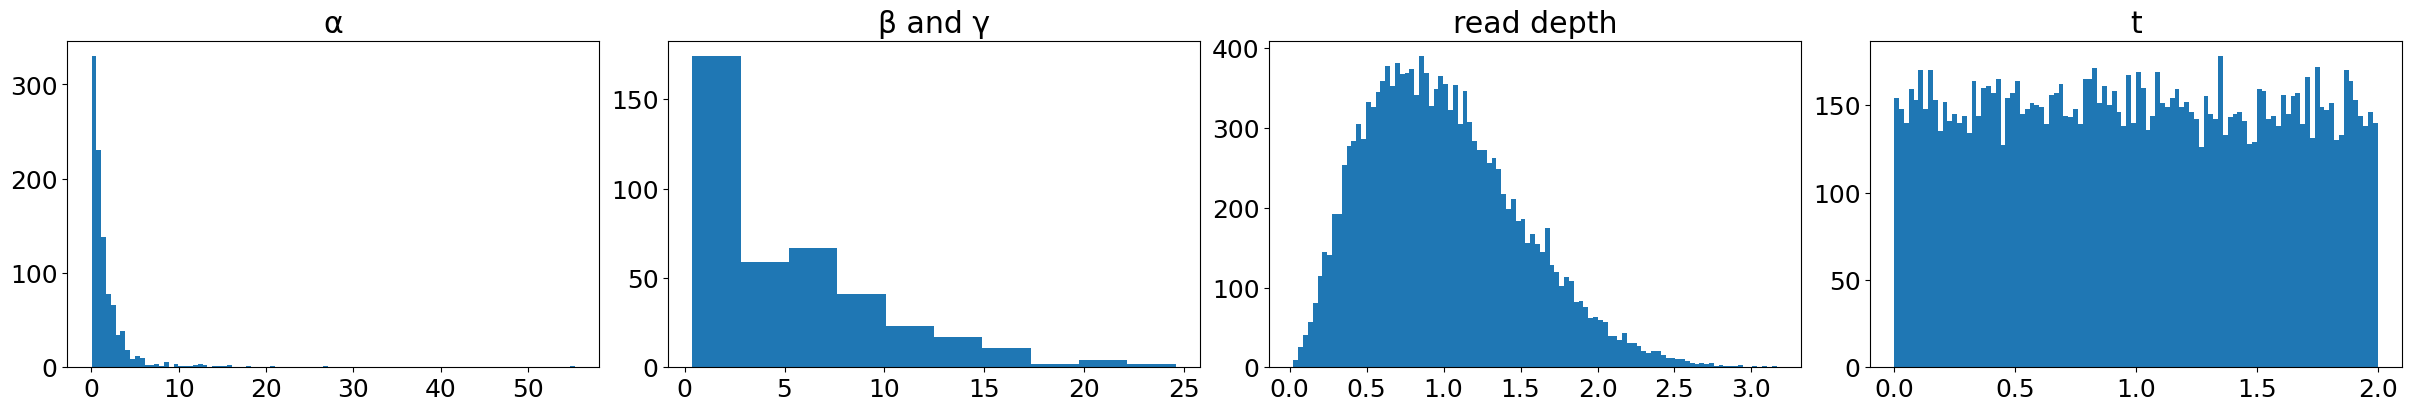

In [5]:
tau = np.array((0,1,2),dtype=float)
topo = np.array([[0,1,2],[0,1,3],[4,4,4]])

L = len(topo)
true_theta, true_t, Y, X, rd = simulate_data(topo, tau, n=5000, random_seed=42, filepath="data/sim_disconnect.h5ad")
X.mean()

In [154]:
adata = ad.read("data/sim_disconnect.h5ad")
true_theta = np.array(adata.varm["theta"])
rd = np.array(adata.obs["read_depth"])
r = rd/rd.mean()
true_t = np.array(adata.obs["time"])
N, p = adata.X.shape
X = np.zeros((N,p,2))
X[:,:,1] = adata.layers["spliced"]
X[:,:,0] = adata.layers["unspliced"]
X.mean()

1.3058463333333334

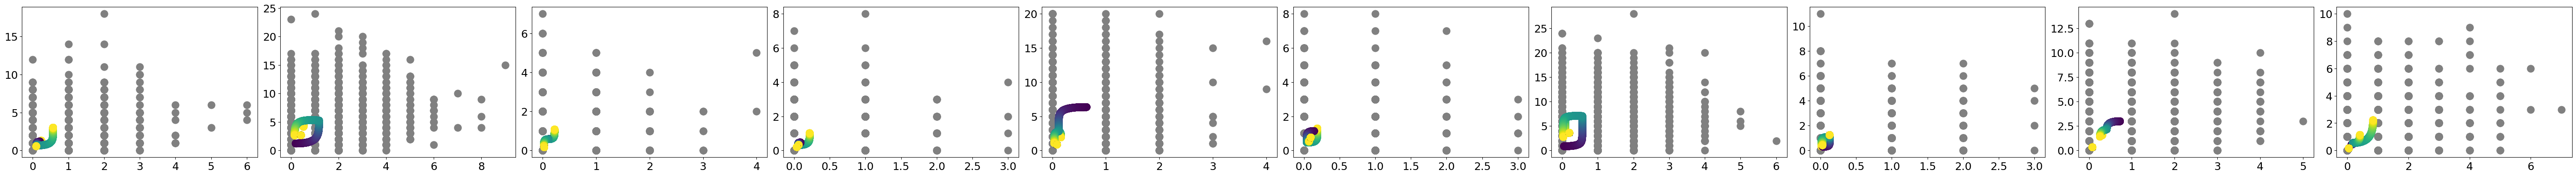

In [7]:
p = 10
fig, ax = plt.subplots(1,p,figsize=(6*p,4))
for i in range(p):
    #ax[i].plot(Y[:,i,1]*gamma[i],Y[:,i,1],'--', color='gray');
    ax[i].scatter(X[:,i,0],X[:,i,1],c='gray');
    ax[i].scatter(Y[:,i,0],Y[:,i,1],c=true_t);
# time increases from blue to red

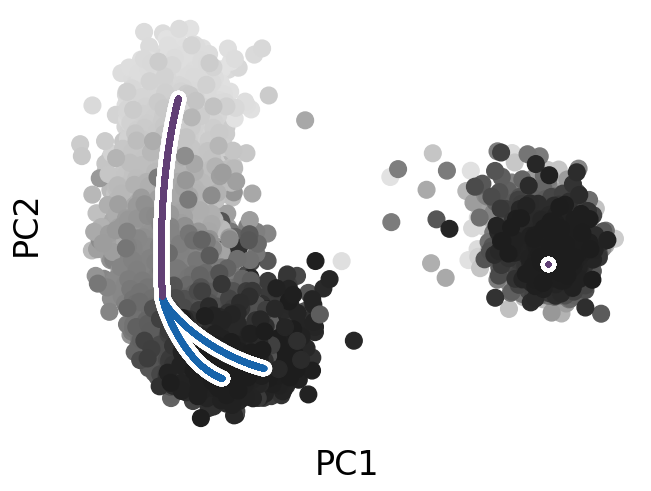

In [8]:
n = len(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.log1p(X[:,:,1]/rd[:,None]*rd.mean()))
Y_pca = pca.transform(np.log1p(Y[:,:,1]))

light_purple = cmr.get_sub_cmap('Purples', 0., 1)(0.25)
purple = '#613f75'
blue = cmr.get_sub_cmap('Blues', 0., 1)(0.8)
red = cmr.get_sub_cmap('Reds', 0., 1)(0.8)

cmap_t = cmr.get_sub_cmap('Greys', 0.2, 0.9)
fig, ax = plt.subplots(1,1)
ax.scatter(X_pca[:,0],X_pca[:,1],c=true_t,cmap=cmap_t);

ax.scatter(Y_pca[(true_t>tau[1])&(true_t <=tau[2]),0],Y_pca[(true_t >tau[1])&(true_t<=tau[2]),1],s=100,color='w');
ax.scatter(Y_pca[(true_t>tau[2]),0],Y_pca[(true_t>tau[2]),1],s=100,color='w');
ax.scatter(Y_pca[(true_t<tau[1]),0],Y_pca[(true_t<tau[1]),1],s=100,color='w');

ax.scatter(Y_pca[(true_t>tau[1])&(true_t<=tau[2]),0],Y_pca[(true_t >tau[1])&(true_t<=tau[2]),1],s=10,color=blue);
ax.scatter(Y_pca[(true_t>tau[2]),0],Y_pca[(true_t>tau[2]),1],s=10,color=red);
ax.scatter(Y_pca[true_t<=tau[1],0],Y_pca[(true_t<=tau[1]),1],s=10,color=purple);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

```
with open('results/simulations_disconnect/topo0_results.pickle', 'rb') as f:
    traj0s = pickle.load(f)
```

# Fit with warm start

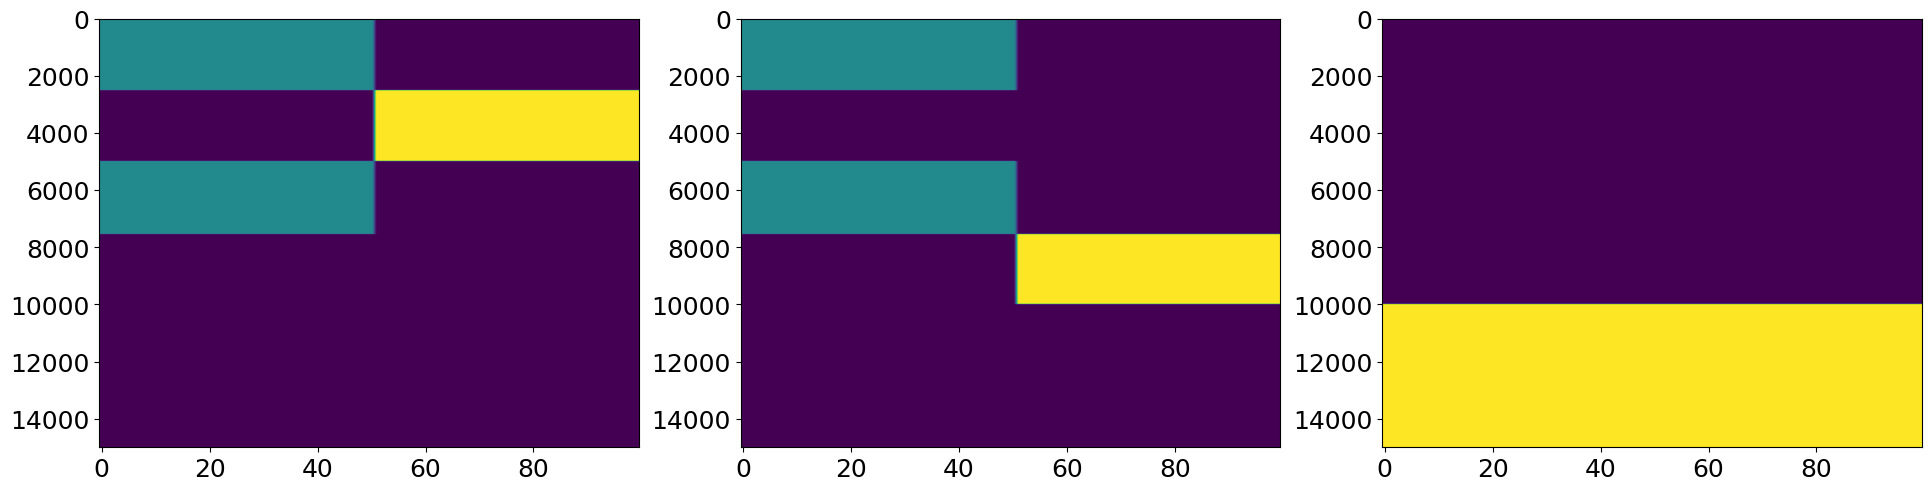

In [9]:
m=100
N=len(X)
Q0 = np.zeros((N,3,m))

idx = (true_t <= tau[1]) & (np.arange(N)<10000)
Q0[idx,:2,:m//2+1] += 1

idx = (true_t > tau[1]) & (true_t <= tau[2]) & (np.arange(N)<5000)
Q0[idx,0,int(m/2)+1:] += 1

idx = (true_t > tau[1]) & (true_t <= tau[2]) & (np.arange(N)>5000) & (np.arange(N)<10000)
Q0[idx,1,int(m/2)+1:] += 1

idx = (np.arange(N)>=10000)
Q0[idx,2,:] += 1

Q0=Q0/Q0.sum(axis=(1,2),keepdims=True)

fig, ax = plt.subplots(1,3,figsize=(19.2,4.8))
ax[0].imshow(Q0[:,0],aspect='auto');
ax[1].imshow(Q0[:,1],aspect='auto');
ax[2].imshow(Q0[:,2],aspect='auto');

fitting with warm start


0it [00:00, ?it/s]


fitting with warm start


100%|██████████| 1/1 [00:10<00:00, 10.28s/it]

(global) tau = [0.         0.98000052 2.        ]


fitting with warm start


100%|██████████| 1/1 [00:07<00:00,  7.71s/it]

(global) tau = [0.         0.96211324 2.        ]


fitting with warm start


100%|██████████| 1/1 [00:06<00:00,  6.59s/it]

(global) tau = [0.         0.95120553 2.        ]


fitting with warm start


100%|██████████| 1/1 [00:06<00:00,  6.62s/it]

(global) tau = [0.         0.94956171 2.        ]


fitting with warm start


100%|██████████| 1/1 [00:06<00:00,  6.46s/it]

(global) tau = [0.         0.95131264 2.        ]


fitting with warm start


100%|██████████| 1/1 [00:05<00:00,  5.81s/it]

(global) tau = [0.         0.95256581 2.        ]


fitting with warm start


100%|██████████| 1/1 [00:06<00:00,  6.27s/it]

(global) tau = [0.         0.95451592 2.        ]


fitting with warm start


100%|██████████| 1/1 [00:06<00:00,  6.85s/it]

(global) tau = [0.         0.95536132 2.        ]


fitting with warm start


100%|██████████| 1/1 [00:05<00:00,  5.74s/it]

(global) tau = [0.         0.96133526 2.        ]


fitting with warm start


100%|██████████| 1/1 [00:05<00:00,  5.75s/it]

(global) tau = [0.         0.96464371 2.        ]


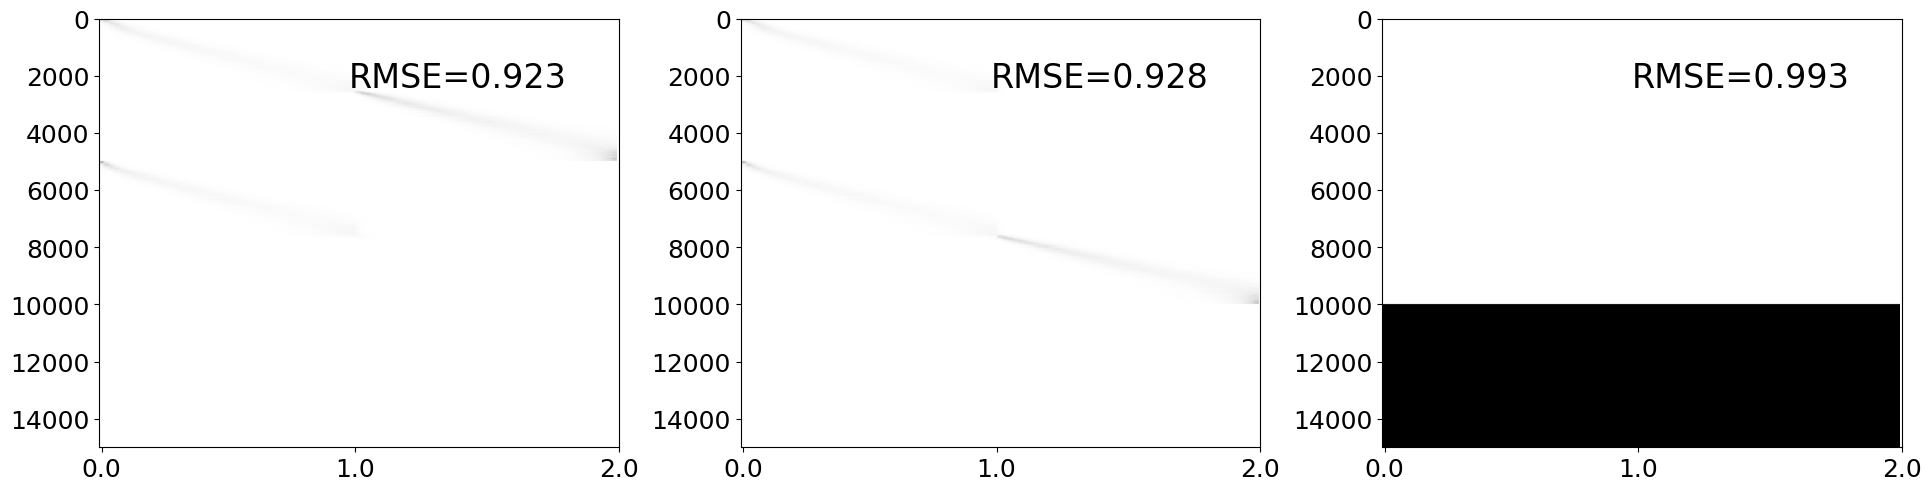

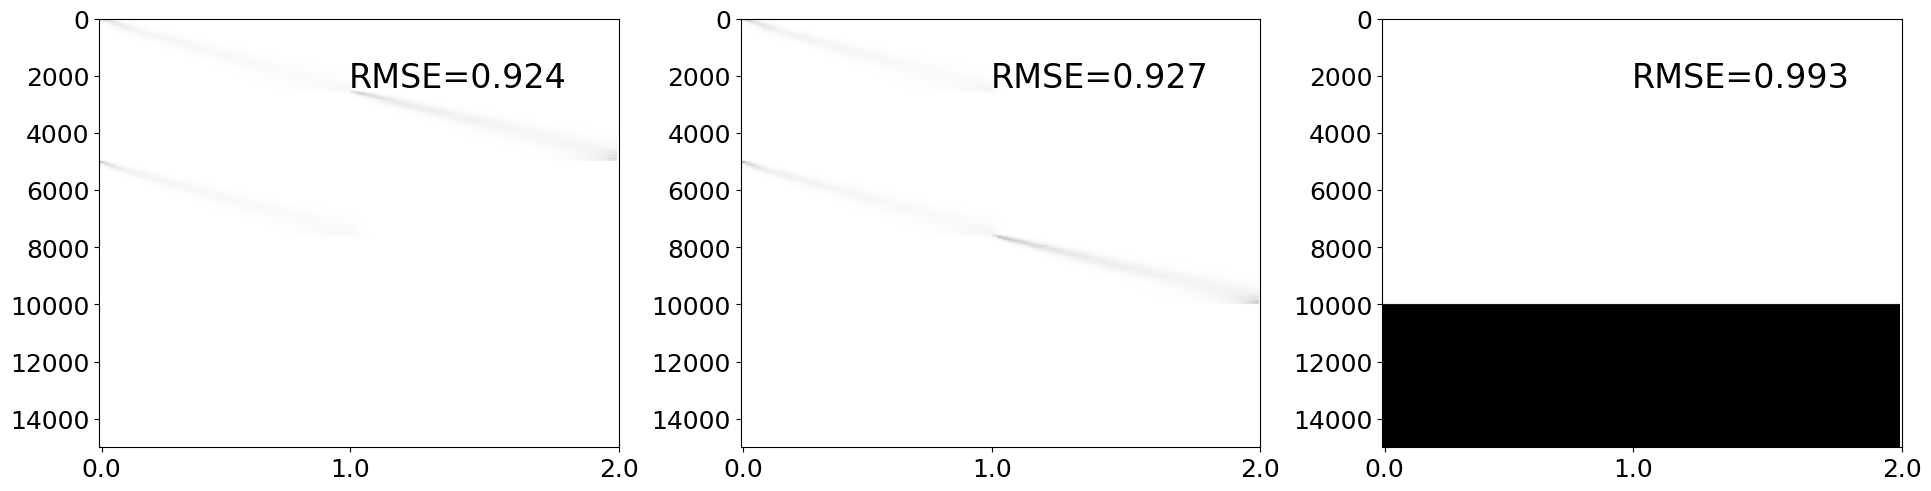

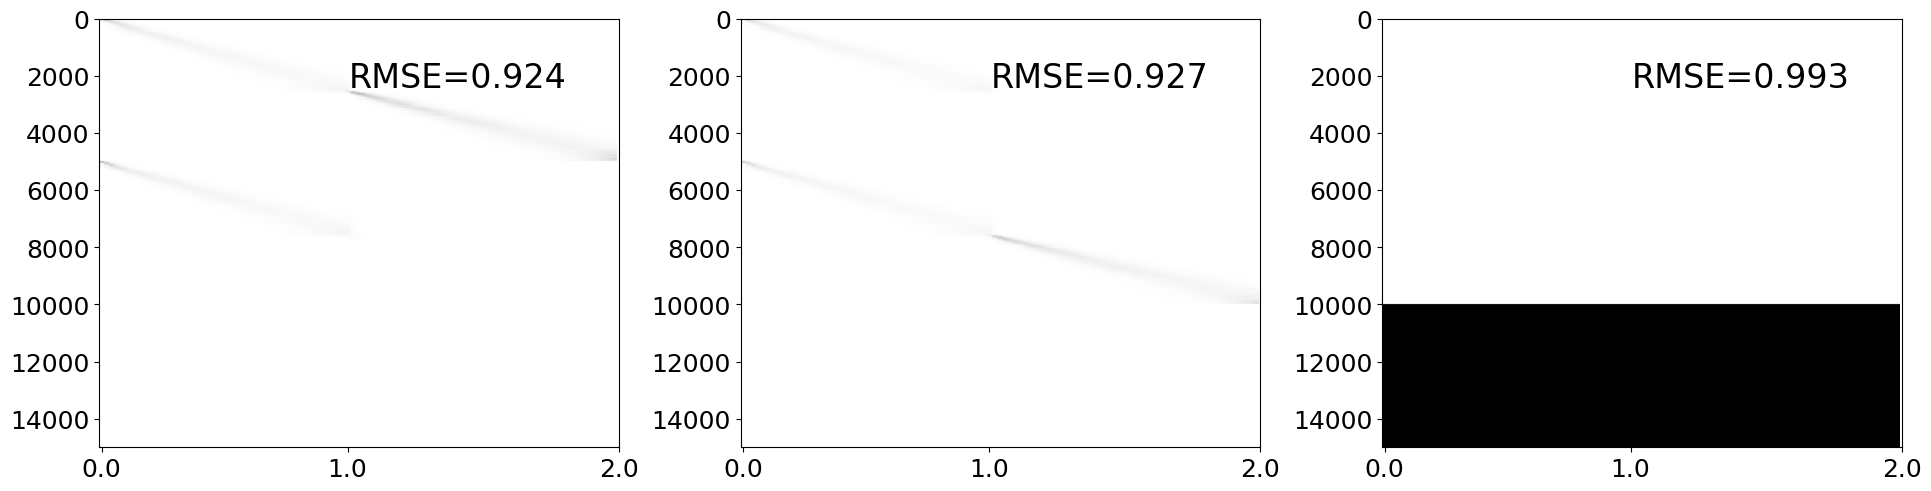

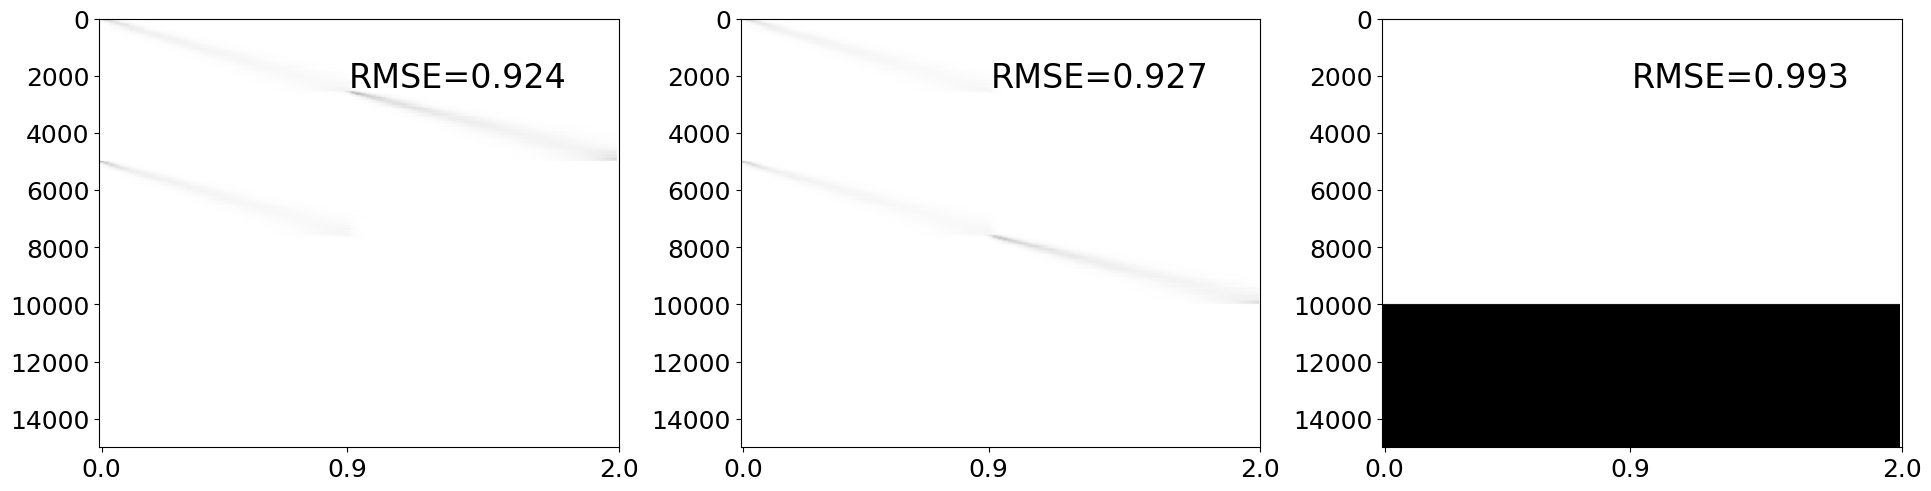

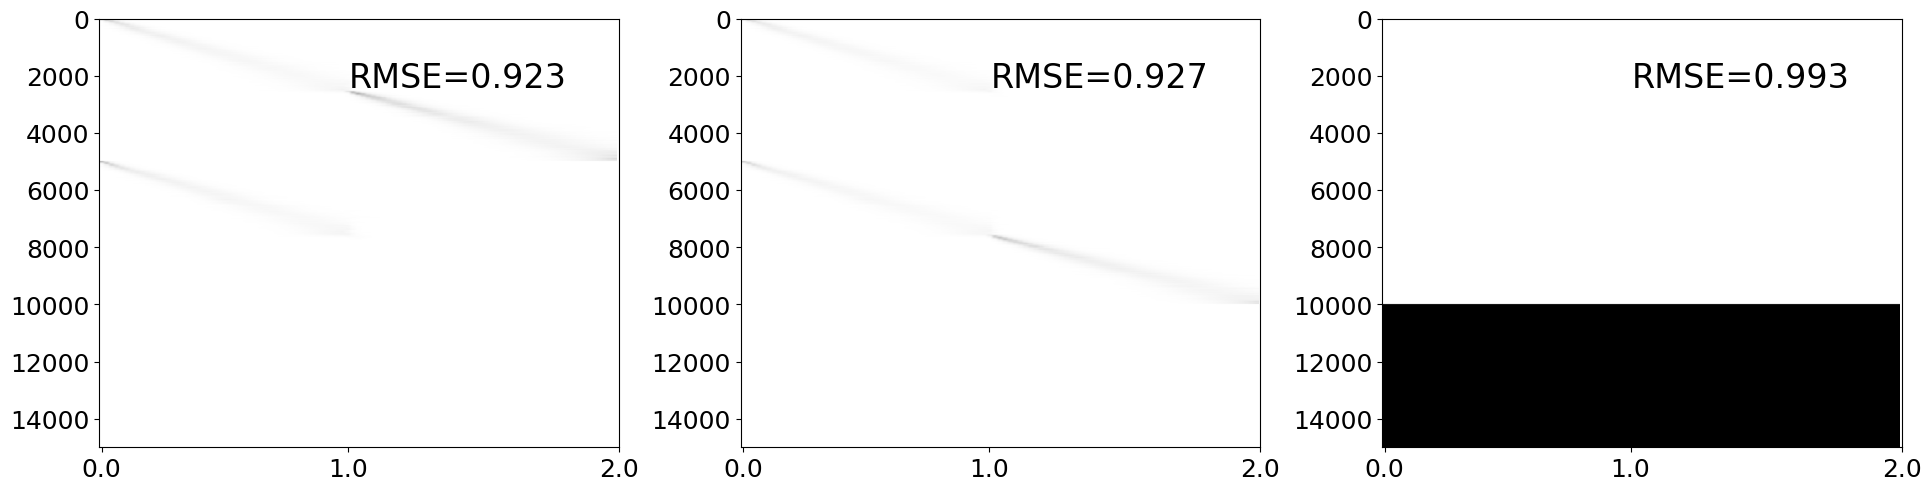

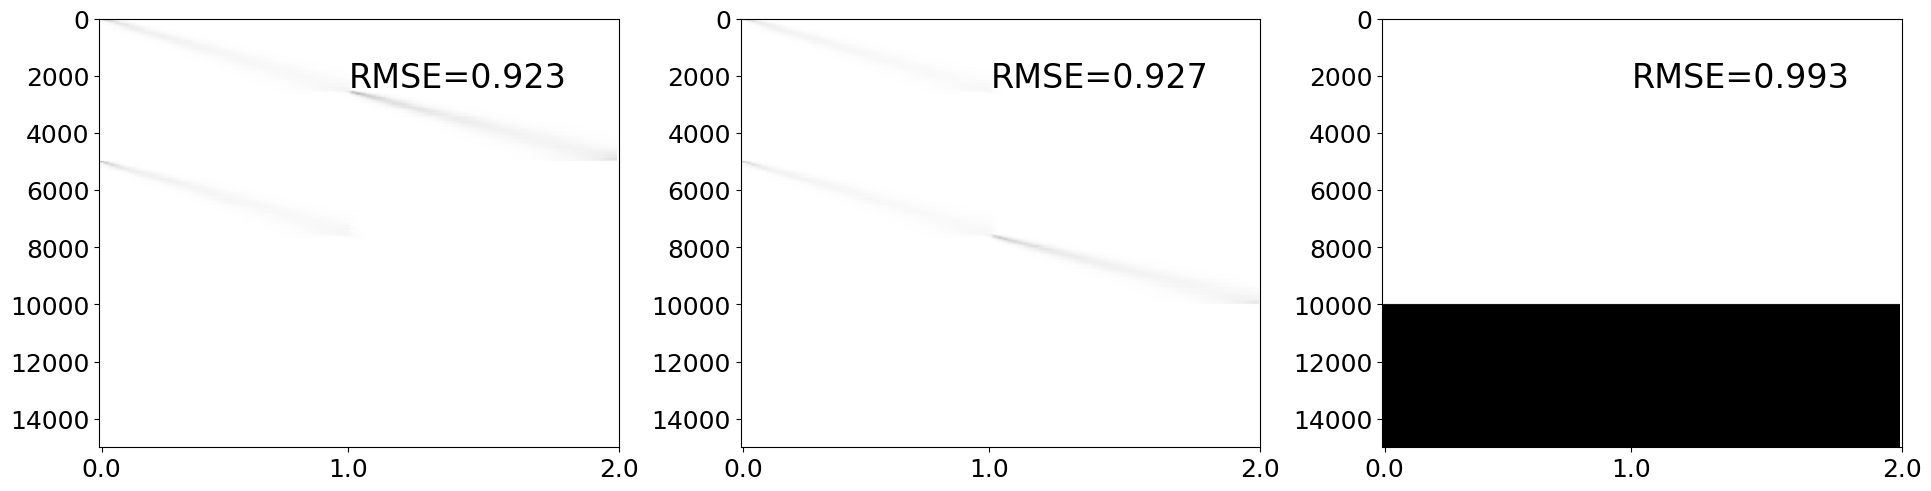

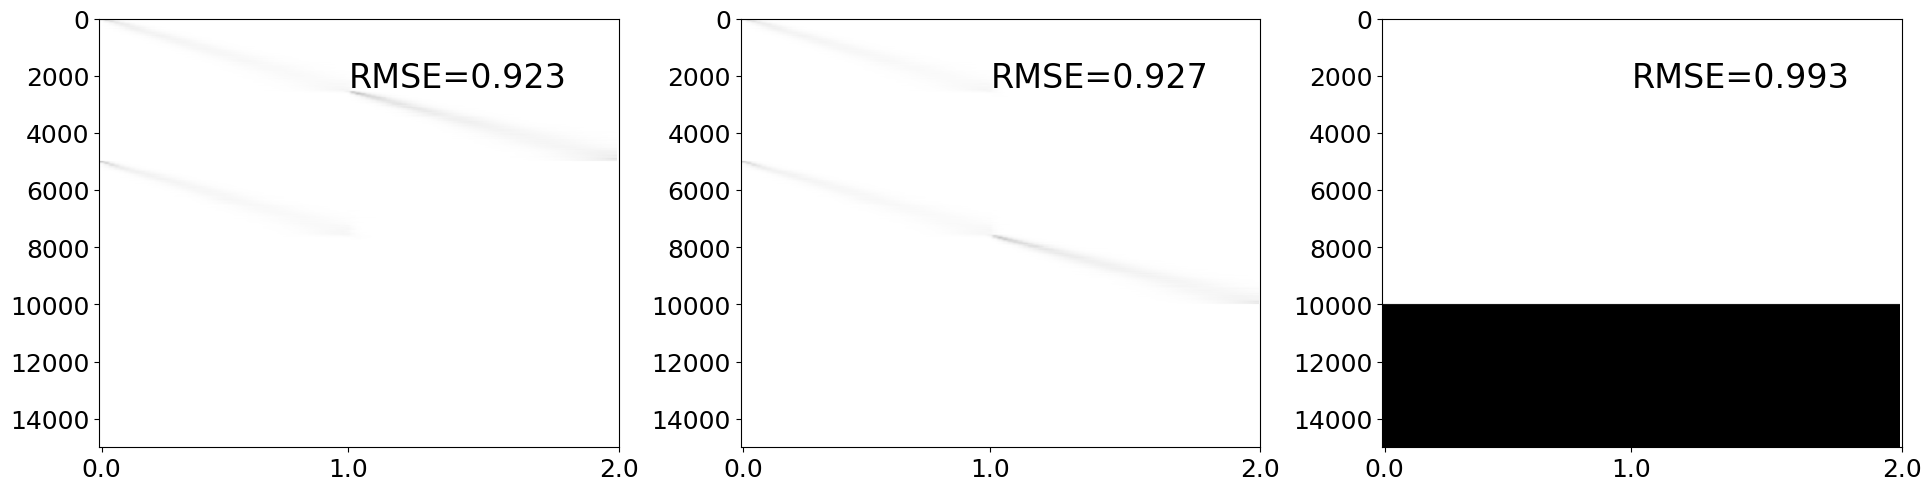

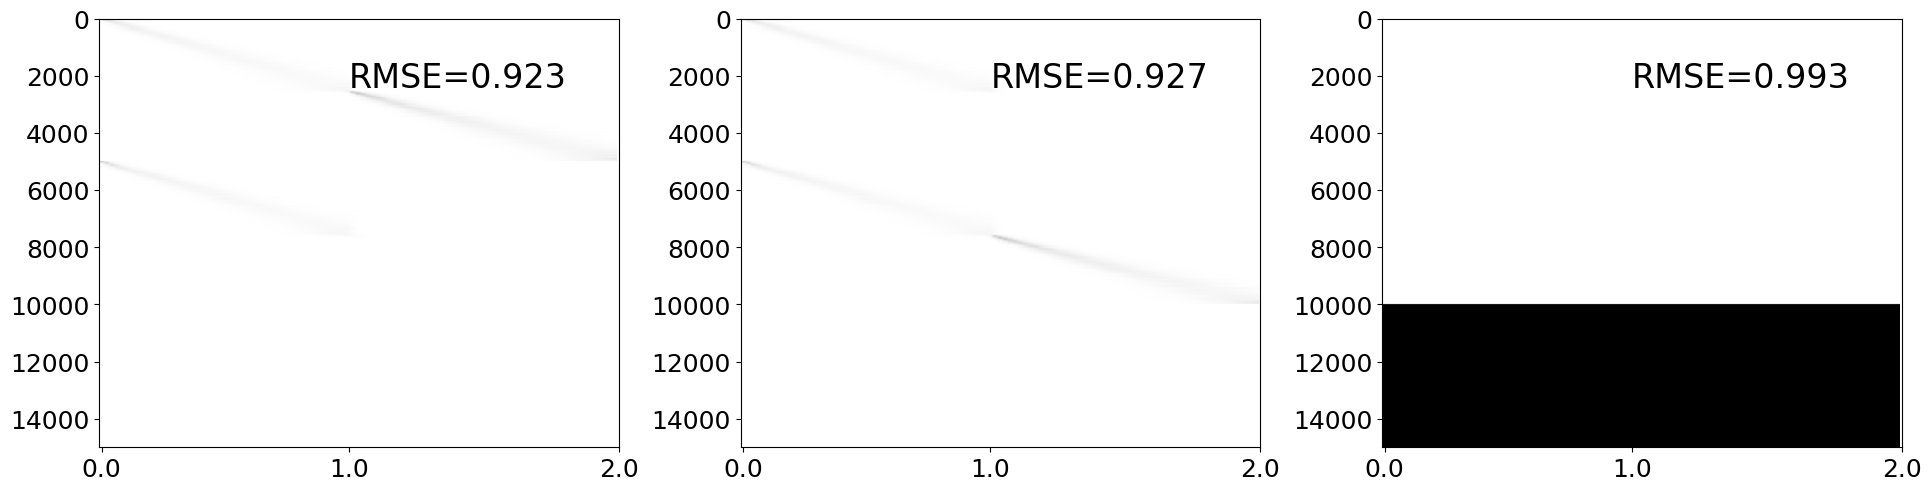

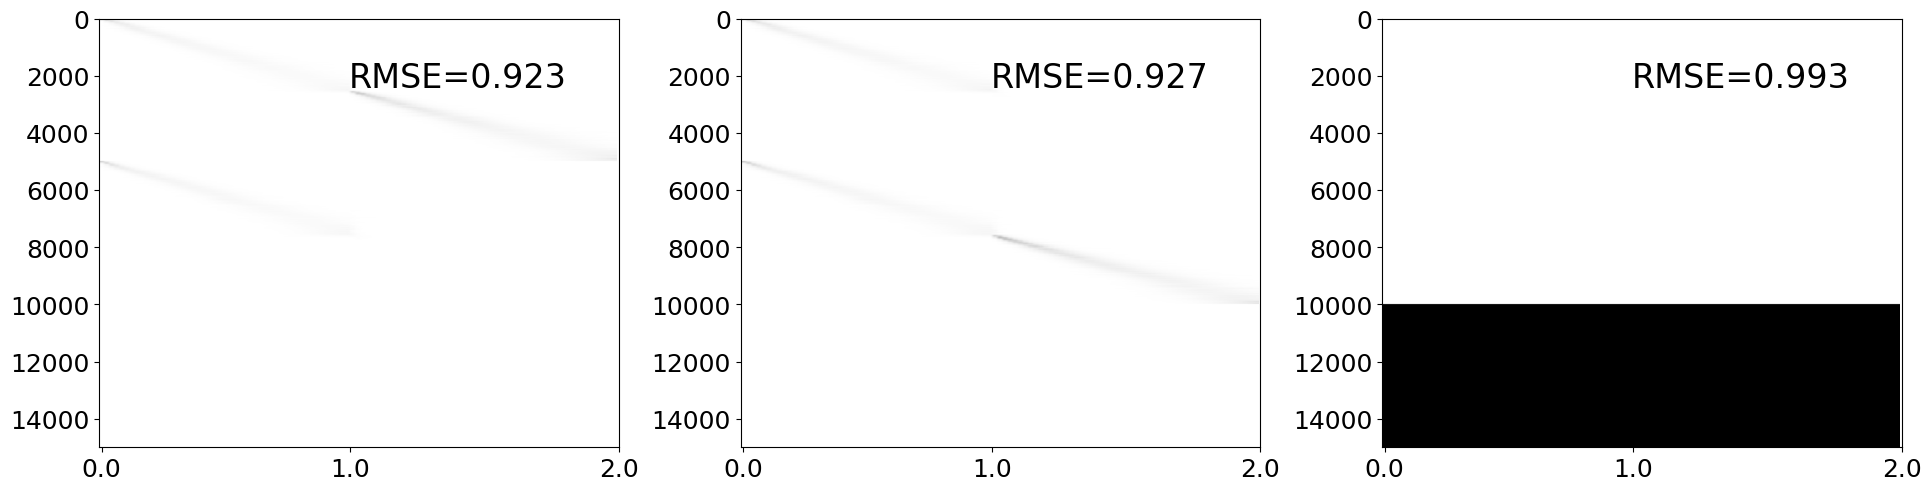

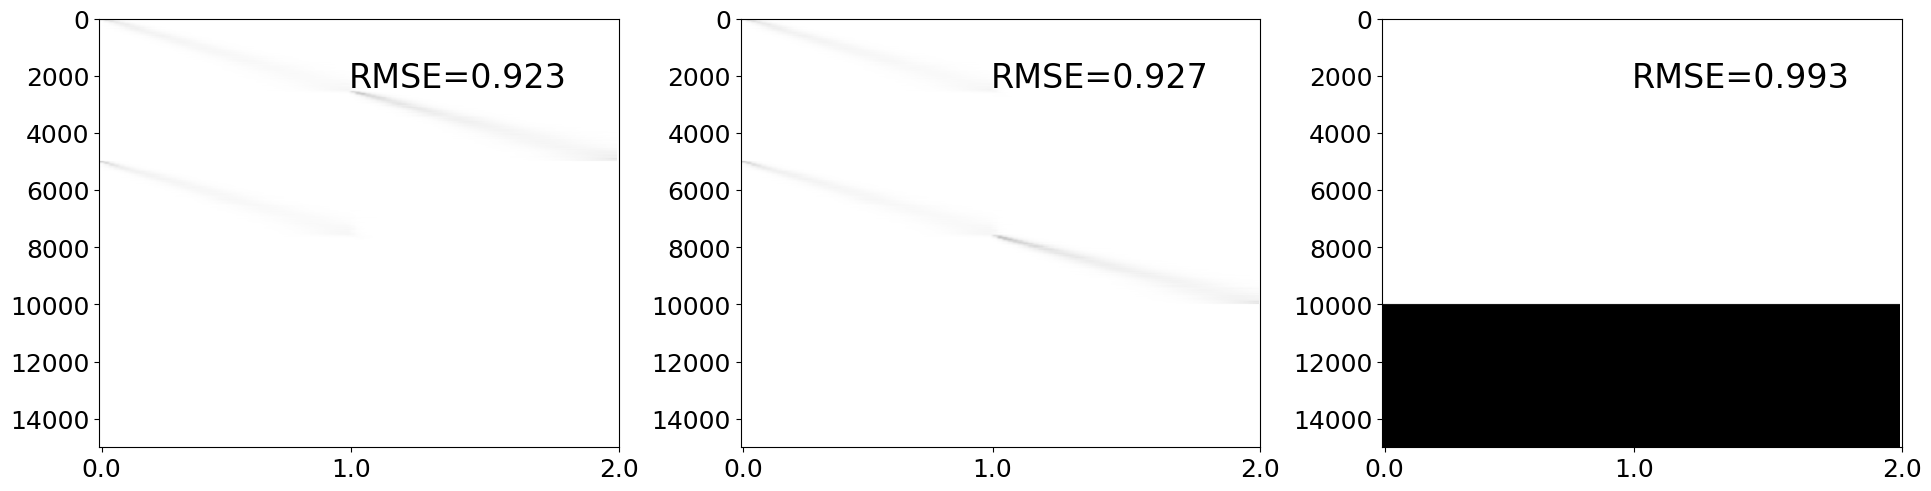

In [10]:
traj = Trajectory(topo, tau, model="two_species_ss", verbose=2)
traj = traj.fit(X,warm_start=True,Q=Q0,fit_tau=True,norm_Q=True,params={"r":rd},epoch=0,parallel=True,n_threads=10)
for e in range(10):
    traj = traj.fit(X,warm_start=True,theta=traj.theta,fit_tau=True,norm_Q=True,params={"r":rd},epoch=1,parallel=True,n_threads=10)
    fig, ax = plt.subplots(1,3,figsize=(19.2,4.8))
    plot_t(traj,l=0,t=true_t,ax=ax[0]);
    plot_t(traj,l=1,t=true_t,ax=ax[1]);
    plot_t(traj,l=2,t=true_t,ax=ax[2]);

In [10]:
traj = Trajectory(topo, tau, model="two_species_ss", verbose=2)
traj = traj.fit(X,warm_start=True,Q=Q0,fit_tau=True,norm_Q=True,params={"r":rd},epoch=100,parallel=True,n_threads=10)
traj.elbos[-1]

fitting with warm start


 20%|██        | 20/100 [01:14<04:51,  3.65s/it]

(global) tau = [0.         1.04032058 2.        ]


 21%|██        | 21/100 [01:25<07:28,  5.68s/it]

beta and gamma multiplied by 1.0569585822576206
(global) tau = [0.         1.06455764 2.        ]


 22%|██▏       | 22/100 [01:35<09:18,  7.16s/it]

beta and gamma multiplied by 1.059685037026158
(global) tau = [0.         1.09757346 2.        ]


 23%|██▎       | 23/100 [01:46<10:37,  8.29s/it]

beta and gamma multiplied by 1.0504521605697559
(global) tau = [0.         1.12100089 2.        ]


 24%|██▍       | 24/100 [01:58<11:37,  9.17s/it]

beta and gamma multiplied by 1.056717784702096
(global) tau = [0.         1.14258246 2.        ]


 25%|██▌       | 25/100 [02:09<12:13,  9.78s/it]

beta and gamma multiplied by 1.060599661231243
(global) tau = [0.         1.16460197 2.        ]


 26%|██▌       | 26/100 [02:20<12:45, 10.35s/it]

beta and gamma multiplied by 1.0420773209724212
(global) tau = [0.         1.20566468 2.        ]


 27%|██▋       | 27/100 [02:32<12:52, 10.59s/it]

beta and gamma multiplied by 1.0233498258758658
(global) tau = [0.         1.22797908 2.        ]


 28%|██▊       | 28/100 [02:42<12:39, 10.55s/it]

beta and gamma multiplied by 1.0306358363604988
(global) tau = [0.         1.24860257 2.        ]


 29%|██▉       | 29/100 [02:53<12:40, 10.70s/it]

beta and gamma multiplied by 1.026445790102366
(global) tau = [0.         1.24943659 2.        ]


 30%|███       | 30/100 [03:04<12:38, 10.83s/it]

beta and gamma multiplied by 1.0264297506166062
(global) tau = [0.         1.26928016 2.        ]


 31%|███       | 31/100 [03:15<12:19, 10.72s/it]

beta and gamma multiplied by 1.0152006611612543
(global) tau = [0.        1.2696646 2.       ]


 32%|███▏      | 32/100 [03:26<12:16, 10.83s/it]

beta and gamma multiplied by 1.0204337982458351
(global) tau = [0.         1.26978099 2.        ]


 33%|███▎      | 33/100 [03:37<12:05, 10.83s/it]

beta and gamma multiplied by 1.00931324665571
(global) tau = [0.         1.25007187 2.        ]


 34%|███▍      | 34/100 [03:47<11:46, 10.70s/it]

beta and gamma multiplied by 0.9997326317660764
(global) tau = [0.         1.26949815 2.        ]


 35%|███▌      | 35/100 [03:57<11:25, 10.54s/it]

beta and gamma multiplied by 1.002585531643926
(global) tau = [0.         1.25043003 2.        ]


 36%|███▌      | 36/100 [04:08<11:15, 10.56s/it]

beta and gamma multiplied by 1.01463987766808
(global) tau = [0.         1.27161158 2.        ]


 37%|███▋      | 37/100 [04:19<11:14, 10.70s/it]

beta and gamma multiplied by 1.005188697448226
(global) tau = [0.         1.25225663 2.        ]


 38%|███▊      | 38/100 [04:30<11:07, 10.77s/it]

beta and gamma multiplied by 1.0073672395104214
(global) tau = [0.         1.27272436 2.        ]


 39%|███▉      | 39/100 [04:43<11:45, 11.56s/it]

beta and gamma multiplied by 1.0037941519684714
(global) tau = [0.         1.25252597 2.        ]


 40%|████      | 40/100 [04:55<11:41, 11.69s/it]

beta and gamma multiplied by 1.0161316595816865
(global) tau = [0.        1.2727274 2.       ]


 41%|████      | 41/100 [05:08<11:47, 11.99s/it]

beta and gamma multiplied by 0.9992620626484175
(global) tau = [0.         1.25252555 2.        ]


 42%|████▏     | 42/100 [05:19<11:29, 11.88s/it]

beta and gamma multiplied by 1.0153853184665673
(global) tau = [0.         1.27272562 2.        ]


 43%|████▎     | 43/100 [05:33<11:44, 12.36s/it]

beta and gamma multiplied by 0.9999255911334258
(global) tau = [0.         1.25252506 2.        ]


 44%|████▍     | 44/100 [05:44<11:14, 12.05s/it]

beta and gamma multiplied by 1.0148858702772963
(global) tau = [0.         1.27272657 2.        ]


 45%|████▌     | 45/100 [05:57<11:07, 12.13s/it]

beta and gamma multiplied by 0.9996337093765951
(global) tau = [0.         1.25252271 2.        ]


 46%|████▌     | 46/100 [06:08<10:43, 11.92s/it]

beta and gamma multiplied by 1.0153064601110668
(global) tau = [0.         1.27272464 2.        ]


 47%|████▋     | 47/100 [06:20<10:34, 11.96s/it]

beta and gamma multiplied by 1.00778064829178
(global) tau = [0.         1.25252594 2.        ]


 48%|████▊     | 48/100 [06:31<10:10, 11.73s/it]

beta and gamma multiplied by 1.019707736446525
(global) tau = [0.         1.27272586 2.        ]


 49%|████▉     | 49/100 [06:44<10:07, 11.92s/it]

beta and gamma multiplied by 1.0024330205000103
(global) tau = [0.         1.25252339 2.        ]


 50%|█████     | 50/100 [06:55<09:43, 11.67s/it]

beta and gamma multiplied by 1.0201121601498473
(global) tau = [0.         1.25252515 2.        ]


 51%|█████     | 51/100 [07:07<09:37, 11.78s/it]

beta and gamma multiplied by 1.0089284387603297
(global) tau = [0.         1.23232309 2.        ]


 52%|█████▏    | 52/100 [07:19<09:25, 11.79s/it]

beta and gamma multiplied by 1.0140526971305754
(global) tau = [0.         1.25252414 2.        ]


 53%|█████▎    | 53/100 [07:30<09:09, 11.68s/it]

beta and gamma multiplied by 1.0085967358265826
(global) tau = [0.         1.23232455 2.        ]


 54%|█████▍    | 54/100 [07:42<08:58, 11.71s/it]

beta and gamma multiplied by 1.0192510402071993
(global) tau = [0.        1.2525237 2.       ]


 55%|█████▌    | 55/100 [07:56<09:18, 12.41s/it]

beta and gamma multiplied by 1.0040107874031121
(global) tau = [0.         1.23232299 2.        ]


 56%|█████▌    | 56/100 [08:08<09:05, 12.40s/it]

beta and gamma multiplied by 1.0200952809991095
(global) tau = [0.         1.21212112 2.        ]


 57%|█████▋    | 57/100 [08:20<08:49, 12.31s/it]

beta and gamma multiplied by 1.0175263545908237
(global) tau = [0.         1.23232484 2.        ]


 58%|█████▊    | 58/100 [08:32<08:32, 12.19s/it]

beta and gamma multiplied by 1.0071329645749276
(global) tau = [0.         1.21212264 2.        ]


 59%|█████▉    | 59/100 [08:44<08:17, 12.13s/it]

beta and gamma multiplied by 1.0242116873045137
(global) tau = [0.         1.19191974 2.        ]


 60%|██████    | 60/100 [08:57<08:12, 12.31s/it]

beta and gamma multiplied by 1.0184489352615744
(global) tau = [0.         1.19192127 2.        ]


 61%|██████    | 61/100 [09:09<08:02, 12.38s/it]

beta and gamma multiplied by 1.011309616007097
(global) tau = [0.         1.17171916 2.        ]


 62%|██████▏   | 62/100 [09:23<08:01, 12.68s/it]

beta and gamma multiplied by 1.0088322954533169
(global) tau = [0.         1.17171712 2.        ]


 63%|██████▎   | 63/100 [09:36<07:49, 12.69s/it]

beta and gamma multiplied by 1.0128725232533269
(global) tau = [0.         1.15151416 2.        ]


 64%|██████▍   | 64/100 [09:49<07:45, 12.94s/it]

beta and gamma multiplied by 1.02342806307878
(global) tau = [0.         1.15151506 2.        ]


 65%|██████▌   | 65/100 [10:02<07:32, 12.93s/it]

beta and gamma multiplied by 1.0087253763867716
(global) tau = [0.         1.15151663 2.        ]


 66%|██████▌   | 66/100 [10:15<07:22, 13.01s/it]

beta and gamma multiplied by 1.0172113280002901
(global) tau = [0.         1.13131424 2.        ]


 67%|██████▋   | 67/100 [10:28<07:09, 13.03s/it]

beta and gamma multiplied by 1.0287986425645934
(global) tau = [0.         1.15151671 2.        ]


 68%|██████▊   | 68/100 [10:41<06:57, 13.06s/it]

beta and gamma multiplied by 1.0115110051185427
(global) tau = [0.         1.13131453 2.        ]


 69%|██████▉   | 69/100 [10:55<06:52, 13.32s/it]

beta and gamma multiplied by 1.0250819931333646
(global) tau = [0.         1.13131275 2.        ]


 70%|███████   | 70/100 [11:10<06:48, 13.60s/it]

beta and gamma multiplied by 1.0104209404286002
(global) tau = [0.       1.111112 2.      ]


 71%|███████   | 71/100 [11:23<06:35, 13.64s/it]

beta and gamma multiplied by 1.017461655005786
(global) tau = [0.         1.13131613 2.        ]


 72%|███████▏  | 72/100 [11:37<06:19, 13.56s/it]

beta and gamma multiplied by 1.0009338210256389
(global) tau = [0.         1.11111503 2.        ]


 73%|███████▎  | 73/100 [11:50<06:06, 13.56s/it]

beta and gamma multiplied by 1.0203428017320646
(global) tau = [0.        1.0909108 2.       ]


 74%|███████▍  | 74/100 [12:04<05:57, 13.74s/it]

beta and gamma multiplied by 1.0109294625119463
(global) tau = [0.         1.11111328 2.        ]


 75%|███████▌  | 75/100 [12:18<05:45, 13.81s/it]

beta and gamma multiplied by 1.0002226839712829
(global) tau = [0.         1.09091298 2.        ]


 76%|███████▌  | 76/100 [12:33<05:36, 14.03s/it]

beta and gamma multiplied by 1.032383635443111
(global) tau = [0.         1.09090885 2.        ]


 77%|███████▋  | 77/100 [12:47<05:22, 14.02s/it]

beta and gamma multiplied by 1.0134905815259945
(global) tau = [0.         1.09091035 2.        ]


 78%|███████▊  | 78/100 [13:01<05:06, 13.95s/it]

beta and gamma multiplied by 1.0179042369952183
(global) tau = [0.         1.07070762 2.        ]


 79%|███████▉  | 79/100 [13:15<04:53, 13.98s/it]

beta and gamma multiplied by 1.013649716485496
(global) tau = [0.         1.07070741 2.        ]


 80%|████████  | 80/100 [13:29<04:40, 14.03s/it]

beta and gamma multiplied by 1.0067371858457088
(global) tau = [0.         1.07071205 2.        ]


 81%|████████  | 81/100 [13:41<04:17, 13.53s/it]

beta and gamma multiplied by 1.013730814514481
(global) tau = [0.         1.05050831 2.        ]


 82%|████████▏ | 82/100 [13:56<04:09, 13.88s/it]

beta and gamma multiplied by 1.009475430458378
(global) tau = [0.         1.05050757 2.        ]


 83%|████████▎ | 83/100 [14:10<03:56, 13.93s/it]

beta and gamma multiplied by 1.0119299759979008
(global) tau = [0.         1.05050685 2.        ]


 84%|████████▍ | 84/100 [14:23<03:40, 13.77s/it]

beta and gamma multiplied by 1.0088671327926075
(global) tau = [0.         1.05050384 2.        ]


 85%|████████▌ | 85/100 [14:37<03:24, 13.62s/it]

beta and gamma multiplied by 1.0112865593954055
(global) tau = [0.         1.03030429 2.        ]


 86%|████████▌ | 86/100 [14:51<03:14, 13.89s/it]

beta and gamma multiplied by 1.019599907992416
(global) tau = [0.         1.03030374 2.        ]


 87%|████████▋ | 87/100 [15:05<03:00, 13.90s/it]

beta and gamma multiplied by 1.0061242115288707
(global) tau = [0.         1.03030466 2.        ]


 88%|████████▊ | 88/100 [15:19<02:46, 13.84s/it]

beta and gamma multiplied by 1.0114333973012606
(global) tau = [0.         1.03030374 2.        ]


 89%|████████▉ | 89/100 [15:32<02:30, 13.65s/it]

beta and gamma multiplied by 1.0079254989562463
(global) tau = [0.         1.03030372 2.        ]


 90%|█████████ | 90/100 [15:44<02:12, 13.24s/it]

beta and gamma multiplied by 1.0061870512453743
(global) tau = [0.         1.01010151 2.        ]


 91%|█████████ | 91/100 [15:59<02:02, 13.62s/it]

beta and gamma multiplied by 1.0109836141510937
normalize Q 98 100
normalize Q 98 100
(global) tau = [0.         1.01010259 2.        ]


 92%|█████████▏| 92/100 [16:13<01:50, 13.82s/it]

beta and gamma multiplied by 1.028408960046899
(global) tau = [0.         1.03030732 2.        ]


 93%|█████████▎| 93/100 [16:26<01:35, 13.69s/it]

beta and gamma multiplied by 1.011901009907807
(global) tau = [0.         1.03030442 2.        ]


 94%|█████████▍| 94/100 [16:40<01:21, 13.59s/it]

beta and gamma multiplied by 1.01728904316928
(global) tau = [0.         1.03030336 2.        ]


 95%|█████████▌| 95/100 [16:53<01:07, 13.46s/it]

beta and gamma multiplied by 1.0141884899944071
(global) tau = [0.         1.01010237 2.        ]


 96%|█████████▌| 96/100 [17:08<00:55, 13.93s/it]

beta and gamma multiplied by 1.0159625063161546
(global) tau = [0.         1.01010133 2.        ]


 97%|█████████▋| 97/100 [17:22<00:41, 13.93s/it]

beta and gamma multiplied by 1.0064462926443527
(global) tau = [0.         1.01010226 2.        ]


 98%|█████████▊| 98/100 [17:35<00:27, 13.69s/it]

beta and gamma multiplied by 1.008758354905482
(global) tau = [0.         1.01010116 2.        ]


 99%|█████████▉| 99/100 [17:48<00:13, 13.58s/it]

beta and gamma multiplied by 1.011774732003775
normalize Q 99 100
normalize Q 99 100
(global) tau = [0.         1.01010197 2.        ]


100%|██████████| 100/100 [18:03<00:00, 10.83s/it]

beta and gamma multiplied by 1.0201108852692424


-428.4483625458941

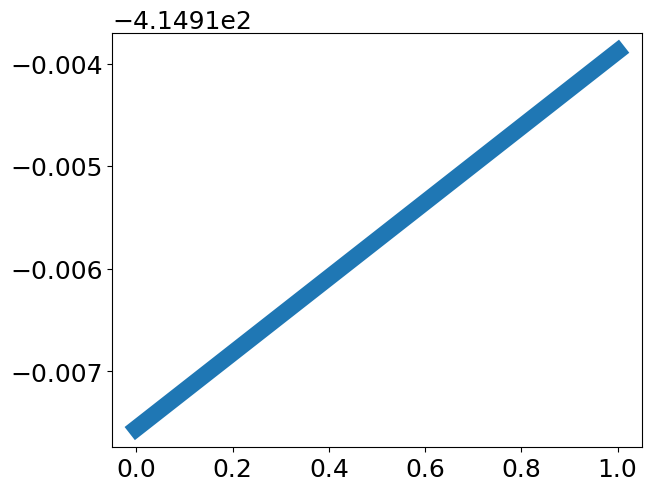

In [11]:
plt.plot(traj.elbos)

In [18]:
traj0_ws = copy.deepcopy(traj)

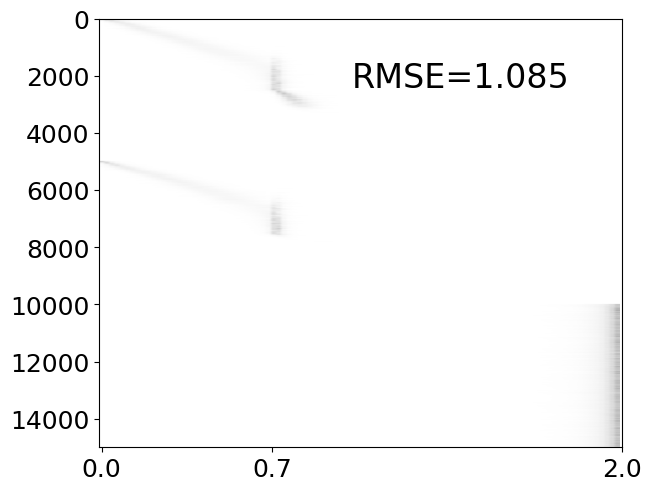

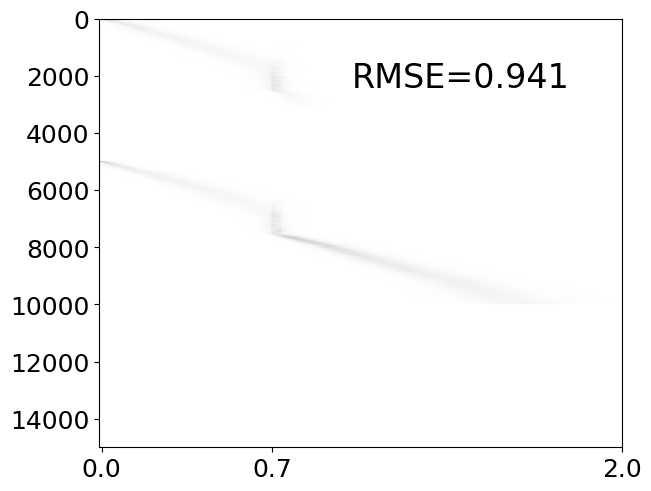

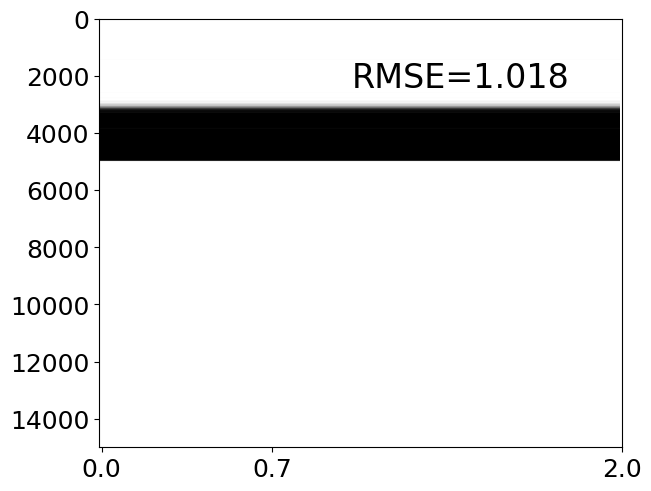

In [138]:
plot_t(traj,l=0,t=true_t);
plot_t(traj,l=1,t=true_t);
plot_t(traj,l=2,t=true_t);

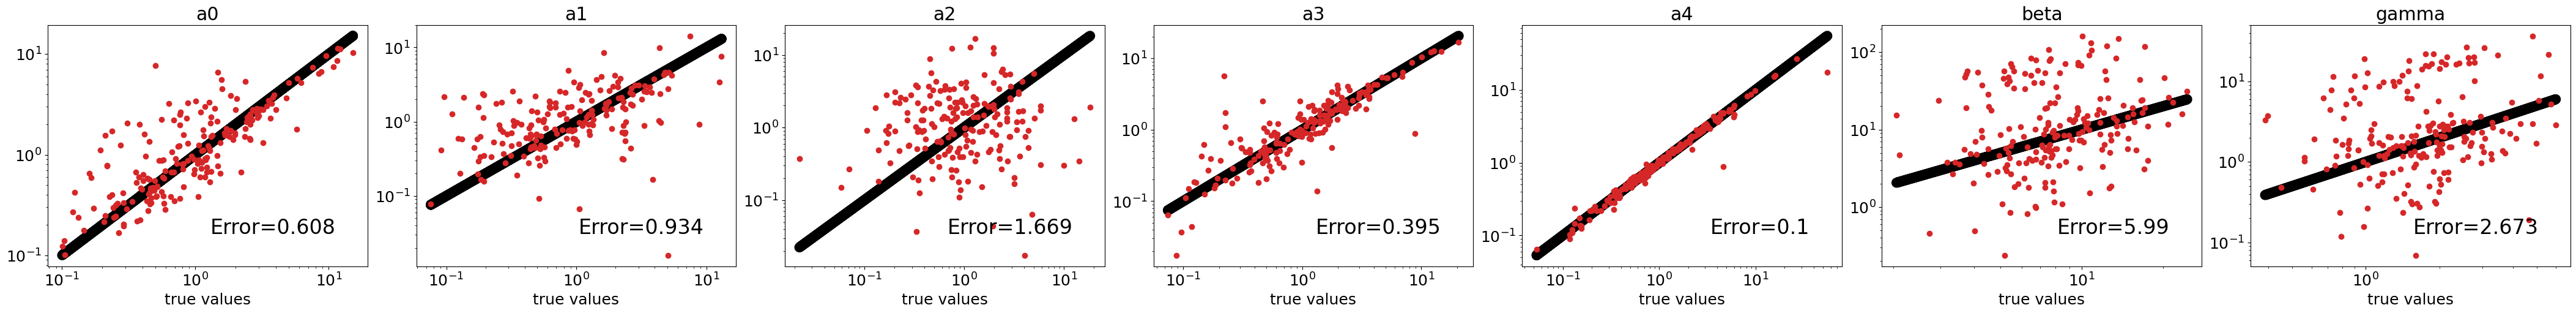

In [20]:
ax = plot_theta(true_theta, traj.theta, dot_color='tab:red')

In [21]:
traj0_ws.compute_lower_bound(X), traj0_ws.compute_AIC(X)

(-428.4483625458941, 12856250.876376823)

# Fit with random initialization

In [ ]:
from multiprocessing import Pool

Input_args = []

def fit_wrapper(seed):
    traj = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,fit_tau=True,norm_Q=True,params={'r':rd},perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(50,100):
    Input_args.append([seed])

ts = time.time()

with Pool(50) as pool:
    trajs_ = pool.starmap(fit_wrapper, Input_args, chunksize=1)
    
print('running time (hour):',(time.time()-ts)/60/60)

In [126]:
traj0s = trajs[:50]
for tr in trajs_:
    traj0s.append(tr)

In [49]:
with open('results/simulations_disconnect/topo0_fix_tau_results.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(trajs, f, pickle.HIGHEST_PROTOCOL)

In [127]:
with open('results/simulations_disconnect/topo0_results.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(traj0s, f, pickle.HIGHEST_PROTOCOL)

In [139]:
with open('results/simulations_disconnect/topo0_results.pickle', 'rb') as f:
    traj0s = pickle.load(f)

-414.95476187719555


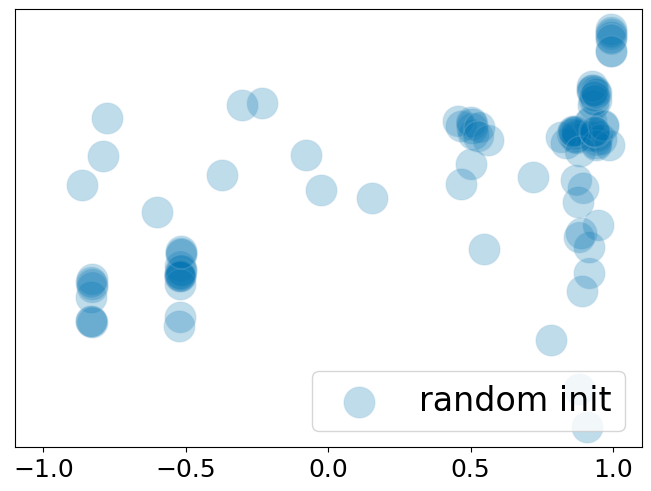

In [144]:
corrs = []
elbos = []
ref_t = true_t
for traj in traj0s:
    t_hat = traj.Q.sum(1) @ traj.t
    corrs.append(stats.pearsonr(ref_t[:10000],t_hat[:10000])[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )

fig, ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.scatter(corrs,elbos,s=2000,marker='.',edgecolors='#98c1d9',color='#0074b3',alpha=0.25,label='random init')
ax.set_xlim((-1.1,1.1))
ax.axes.get_yaxis().set_visible(False)
#ax.set_ylabel('ELBO',fontsize=24);
plt.legend(loc="lower right",fontsize=legend_font);

traj0 = traj0s[np.argmax(elbos)]
print(np.max(elbos))

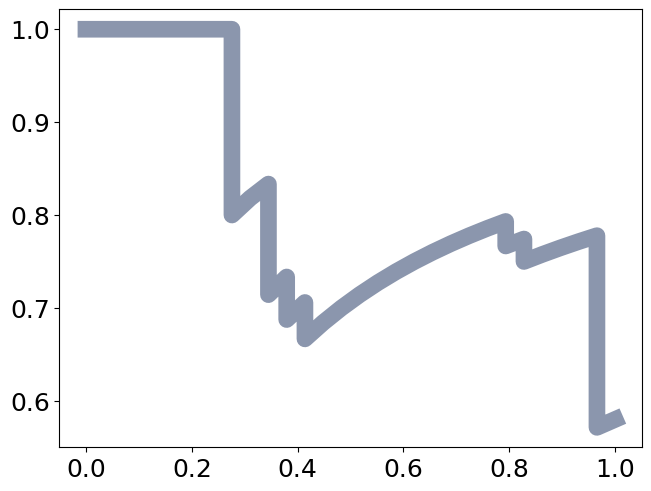

In [105]:
from sklearn.metrics import average_precision_score, precision_recall_curve

corrs = np.array(corrs)
elbos = np.array(elbos)
is_correct_direction = np.array(corrs>0.8,dtype=bool)
corrs_ratio = np.mean(is_correct_direction)

precision, recall, thresholds = precision_recall_curve(y_true=is_correct_direction,probas_pred=elbos)
score =  average_precision_score(y_true=is_correct_direction, y_score=elbos)
plt.plot(recall, precision,'.-',color='#8b96ad',label=np.around(score,3))

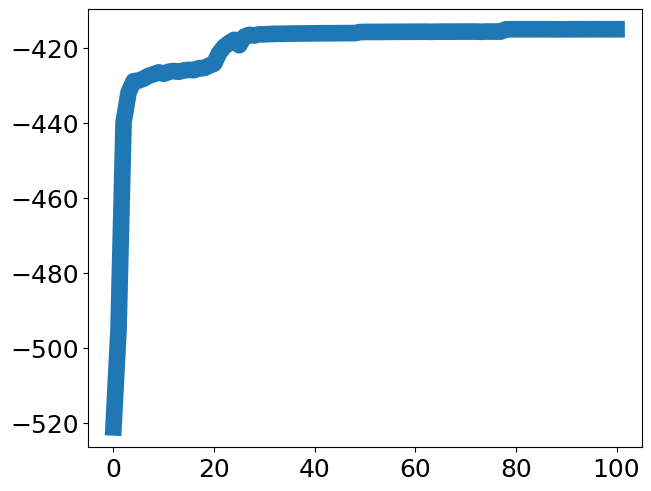

In [145]:
plt.plot(traj0.elbos[0])

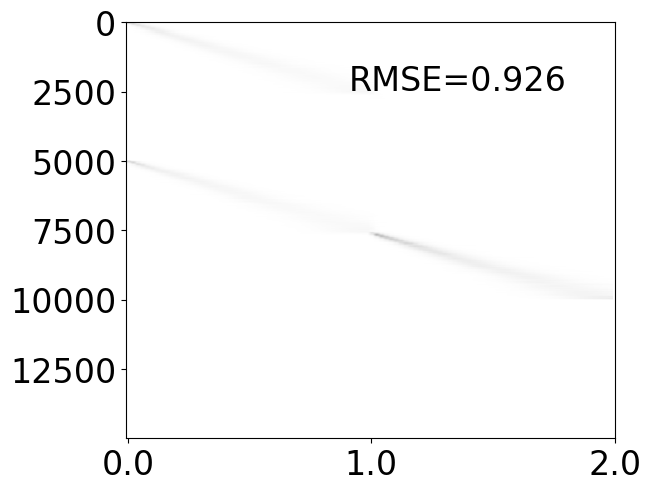

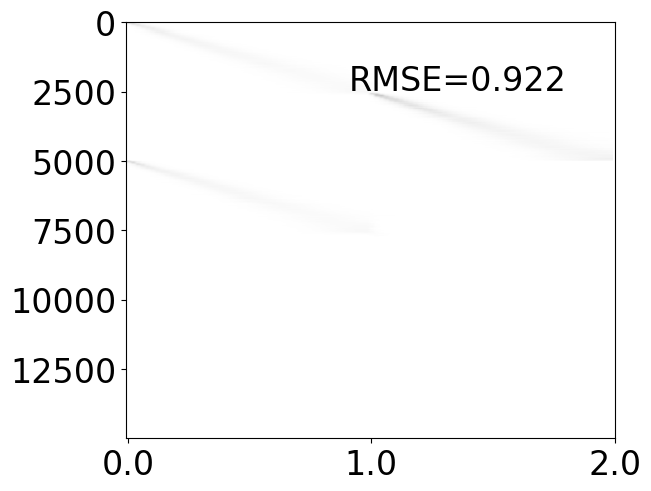

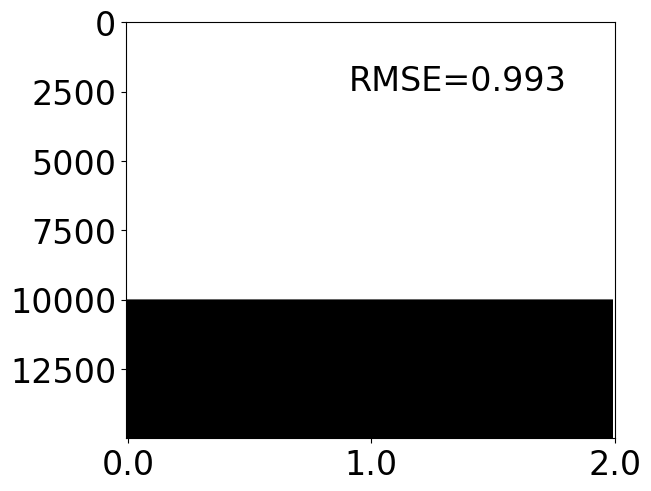

In [152]:
plot_t(traj0,l=0,t=true_t);
plot_t(traj0,l=1,t=true_t);
plot_t(traj0,l=2,t=true_t);

## Q plot

In [159]:
cmap_state_1 = cmr.get_sub_cmap('Purples', 0.2, 1)
cmap_state_2 = cmr.get_sub_cmap('Blues', 0.2, 1)
cmap_state_3 = cmr.get_sub_cmap('Reds', 0.2, 1)
cmap_state_4 = cmr.get_sub_cmap('Oranges', 0.2, 1)

In [160]:
traj = copy.deepcopy(traj0)

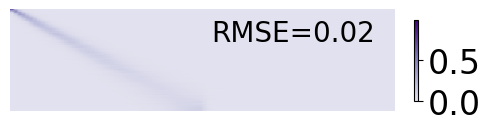

In [189]:
import matplotlib.colors as colors

color_palette = ['#d1e2e5','#458b94']
cmap_Q = colors.LinearSegmentedColormap.from_list("my_cmap", color_palette, N=1000)

plt.rcParams['font.size'] = '24'
fig, ax = plt.subplots(1,1,figsize=(4.8,1.2))

cell_idx = (true_t<1) & (np.arange(N)<10000)
cell_order = np.argsort(true_t[cell_idx])
Z = traj.Q[cell_idx].sum(axis=-2)
im = ax.imshow(Z[cell_order ],aspect="auto",cmap=cmap_state_1);

t_hat=traj.Q.sum(1)@traj.t
ax.text(0.95, 0.9, "RMSE="+str(np.around(np.sqrt(((t_hat[cell_idx]- true_t[cell_idx])/traj.tau[-1])**2).mean(),2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=20);
cbar = plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
ax.axis('off');
#ax.set_xticks([0,50,100])

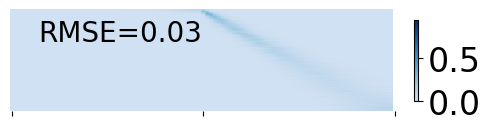

In [185]:
fig, ax = plt.subplots(1,1,figsize=(4.8,1.2))

color_palette = ['#A2C5CA','#0e3442']
cmap_Q = colors.LinearSegmentedColormap.from_list("my_cmap", color_palette, N=1000)

cell_idx = (true_t>=1) & (true_t<2) & (np.arange(N)<5000)
t_hat=traj.Q[:,0,:]@traj.t+traj.Q[:,1,:]@traj.t
Z = traj.Q[cell_idx,0,:] + traj.Q[cell_idx,1,:]
im = ax.imshow(Z[np.argsort(true_t[cell_idx])],aspect="auto",cmap=cmap_state_2);
ax.text(0.5, 0.9, "RMSE="+str(np.around(np.sqrt(((t_hat[cell_idx]- true_t[cell_idx])/traj.tau[-1])**2).mean(),2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=20);
plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

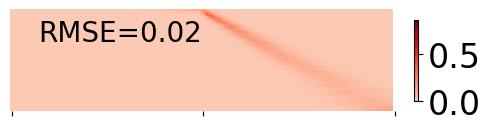

In [184]:
fig, ax = plt.subplots(1,1,figsize=(4.8,1.2))

cell_idx = (true_t>=1) & (np.arange(N)<10000) & (np.arange(N)>=5000)
Z = traj.Q[cell_idx][np.argsort(true_t[cell_idx])].sum(-2)
im = ax.imshow(Z,aspect="auto",cmap=cmap_state_3);

t_hat=traj.Q.sum(1)@traj.t
ax.text(0.5, 0.9, "RMSE="+str(np.around(np.sqrt(((t_hat[cell_idx]- true_t[cell_idx])/traj.tau[-1])**2).mean(),2)), horizontalalignment='right', 
                 verticalalignment='top', transform=ax.transAxes, color="black",fontsize=20);
plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = []
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

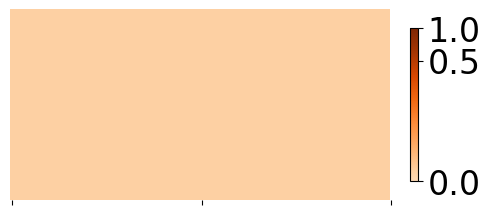

In [183]:
fig, ax = plt.subplots(1,1,figsize=(4.8,2))

import matplotlib.colors as colors
def _forward(x):
    return np.log(0.05+x)

def _inverse(x):
    return np.exp(x)-0.05

norm = colors.FuncNorm((_forward, _inverse), vmin=0, vmax=1)

cell_idx =  (np.arange(N)>=10000)
Z = traj.Q[cell_idx].sum(-2)
im = ax.imshow(Z,aspect="auto",cmap=cmap_state_4, norm=norm);

t_hat=traj.Q[:,2]@traj.t
#ax.text(0.5, 0.9, "RMSE="+str(np.around(np.sqrt(((t_hat[cell_idx]- true_t[cell_idx])/traj.tau[-1])**2).mean(),2)), horizontalalignment='right', 
                 #verticalalignment='top', transform=ax.transAxes, color="black",fontsize=20);
plt.colorbar(im,fraction=0.2, shrink =0.8) # adding the colobar on the right
x_label_list = []
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list)
ax.set_yticks([])
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

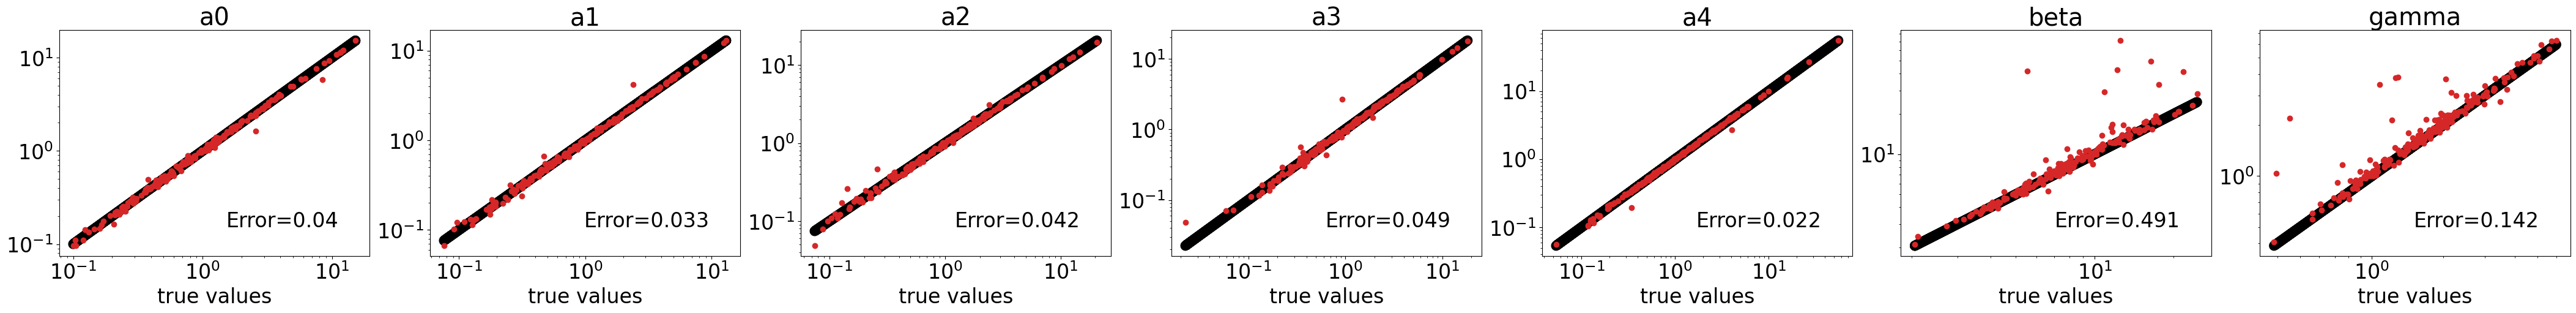

In [190]:
plot_theta(true_theta[:,[0,1,3,2,4,-2,-1]],traj0.theta);

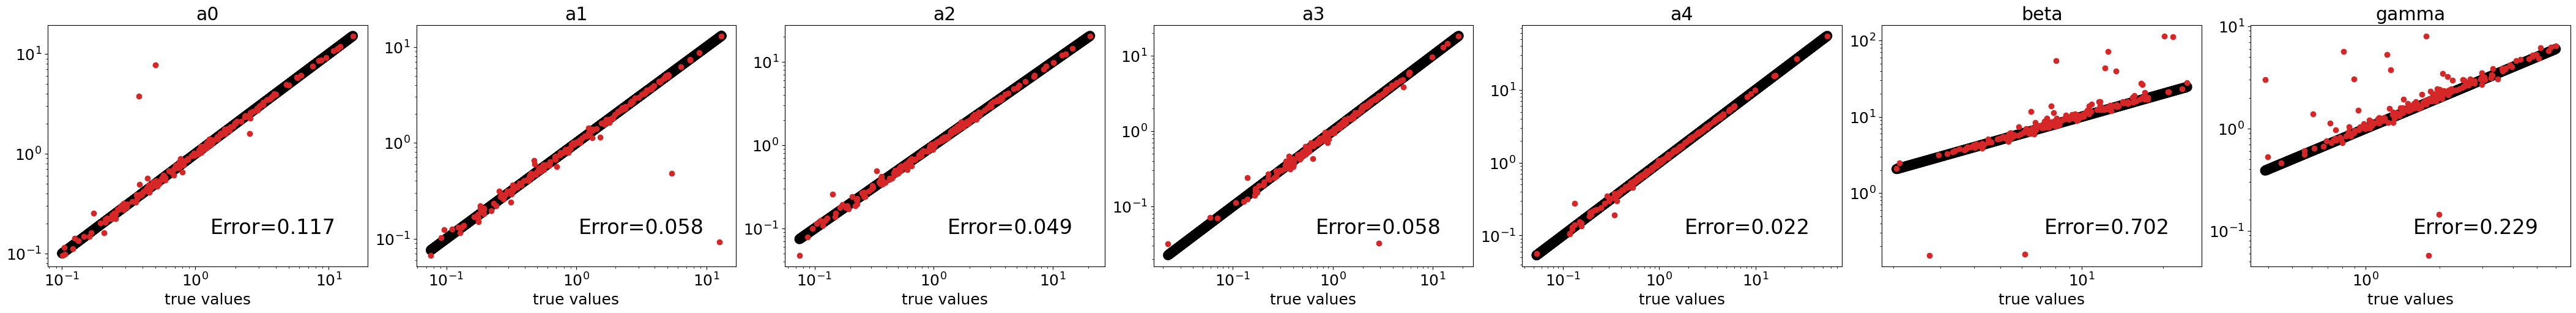

In [42]:
plot_theta(true_theta[:,[0,1,3,2,4,-2,-1]],traj.theta);

In [47]:
traj0.elbos[0][-1], traj.elbos[0][-1]

(-414.95476187719555, -415.3849268549897)

In [43]:
# Complete likelihood (given latent viariable) with true parameter
complete_L = np.mean((X*np.log(r[:,None,None]*Y)-r[:,None,None]*Y-gammaln(X+1)).sum(axis=(-1,-2)))
complete_L

-412.47942618645163

In [44]:
theta = true_theta.copy()
traj_true = Trajectory(topo, tau, model="two_species_ss", verbose=1)
traj_true = traj_true.fit(X,warm_start=True,theta=true_theta,fit_tau=False,norm_Q=True,params={"r":rd},epoch=0,parallel=False,n_threads=1)
true_L = traj_true.elbos
true_L

fitting with warm start


0it [00:00, ?it/s]


[-414.8703893076256]

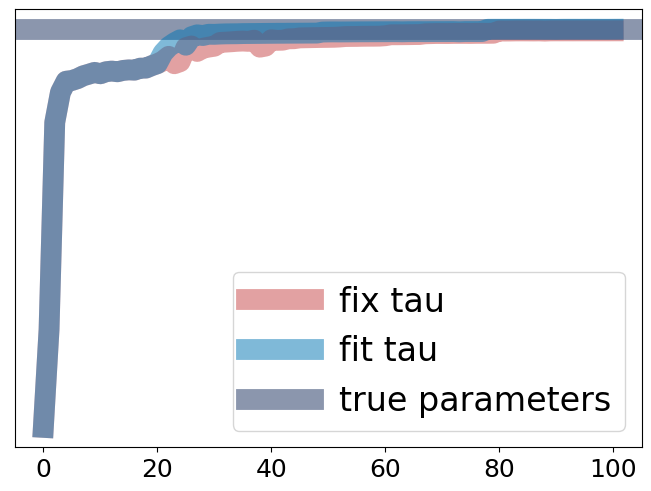

In [45]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.8))

ax.plot(traj.elbos[0],'-',linewidth=15,markersize=30,label='fix tau',color='#c74546',alpha=0.5)
ax.plot(traj0.elbos[0],'-',linewidth=15,markersize=30,label='fit tau',color='#0074b3',alpha=0.5)

ax.axhline(y=true_L,ls='-',linewidth=15,color='#8b96ad',label='true parameters',zorder=0)
#ax.axhline(y=complete_L,ls='--',color='rosybrown',label='complete data likelihood')

#ax.set_xlabel('Iterations')
ax.axes.get_yaxis().set_visible(False)
#ax.set_ylabel('ELBO',fontsize=24);
plt.legend(loc="lower right",fontsize=legend_font);

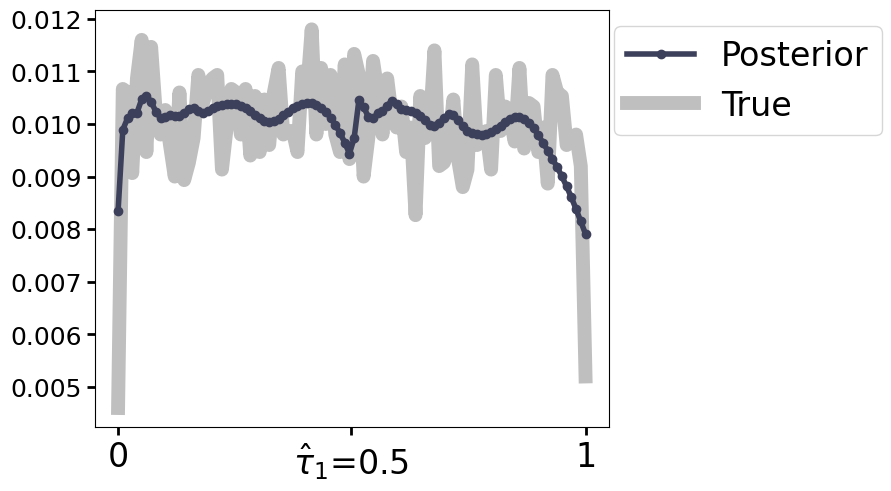

In [32]:
fig,ax = plt.subplots(figsize=(8.8,4.8))
ax.plot(traj.t,traj.Q.sum((0,1))/traj.Q.sum(),'.-',color="#3d405b",linewidth=4,label='Posterior');
t_intv = traj.tau[-1]-traj.tau[0]
grid_size = t_intv/(traj.m-1)
hist, bin_edges = np.histogram(true_t,bins=np.linspace(traj.tau[0],traj.tau[-1]+grid_size,traj.m+1)-grid_size/2,density=True)
ax.plot((bin_edges[:-1]+bin_edges[1:])/2,hist*grid_size,color='gray',linewidth=10,alpha=0.5,zorder=0,label='True')

x_label_list = ['0', r'$\hat{\tau}_1$='+str(np.around(traj.tau[1]/traj.tau[-1],2)),'1']
ax.tick_params(direction='out', length=6, width=2)
ax.set_xticks(traj.tau)
ax.set_xticklabels(x_label_list,fontsize=24)
ax.legend(loc=(1.01,0.7),fontsize=24)

# Model comparison 

## Applying model comparison on this datasets

In [64]:
PMSS = PoissonMixtureSS(n_components=5,verbose=1)
Q, lower_bound = PMSS.fit(X, warm_start=False, read_depth=rd, n_init=10, epoch=10)
PMSS.Q = Q
PMSS.elbo = lower_bound

read_depth is not normalized


100%|██████████| 10/10 [00:35<00:00,  3.56s/it]


In [66]:
PMSS.compute_AIC(X,standard=True),PMSS.compute_AIC(X),lower_bound

(12705927.218461601, -423.53090728205336, -423.4506406153867)

In [52]:
topo1 = np.array([[0,1,2],[0,1,3],[0,1,4]])
topo2 = np.array([[0,1,2],[0,1,3],[4,5,6]])

m=100
L=len(topo)

In [53]:
from multiprocessing import Pool

Input_args = []

def fit_wrapper(seed):
    traj = Trajectory(topo1, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,fit_tau=True,norm_Q=True,params={'r':rd},perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
ts = time.time()
with Pool(25) as pool:      
    trajs1 = pool.starmap(fit_wrapper, Input_args, chunksize=1)
print((time.time()-ts)/60/60)

3.8989856872293687


In [54]:
with open('results/simulations_disconnect/topo1_results.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(trajs1, f, pickle.HIGHEST_PROTOCOL)

-417.0223878092107


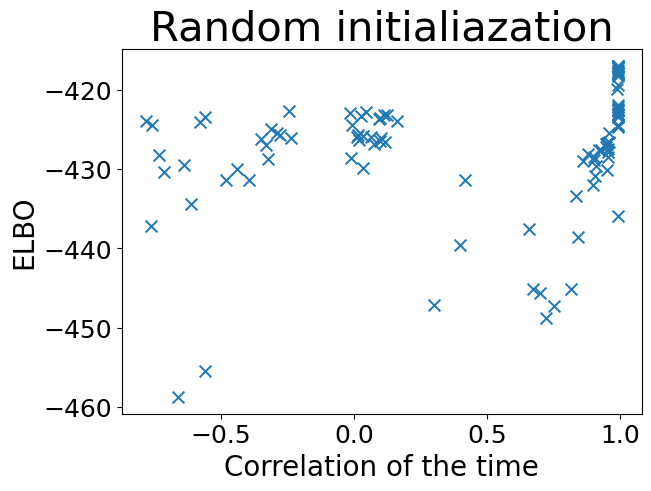

In [99]:
corrs = []
elbos = []
right_t = true_t
for traj in trajs1:
    t_hat = traj.Q.sum(1) @ traj.t
    corrs.append(stats.pearsonr(right_t[:10000],t_hat[:10000])[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,s=1,marker='x')
#plt.axhline(y=Elbos['warm start'],color='gray')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

traj1 = trajs1[np.argmax(elbos)]
print(np.max(elbos))

In [73]:
traj2.fit_global_tau

False

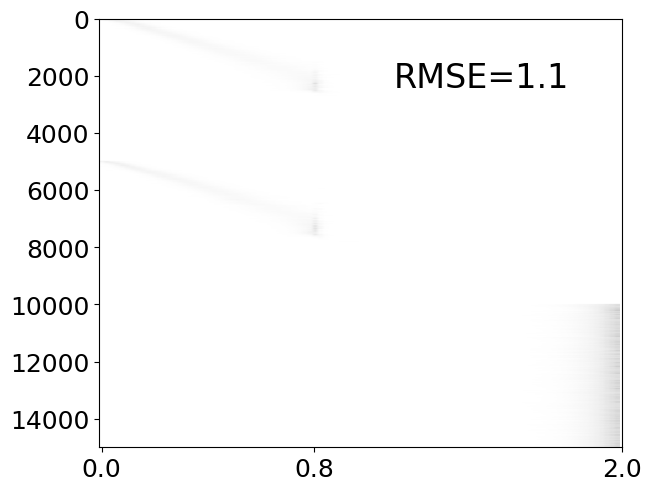

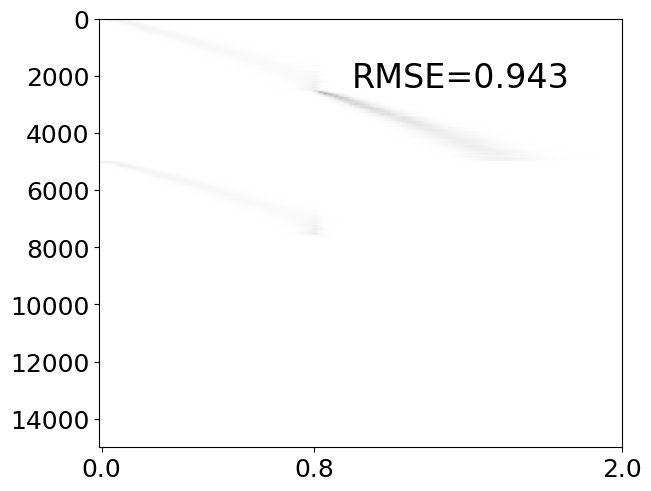

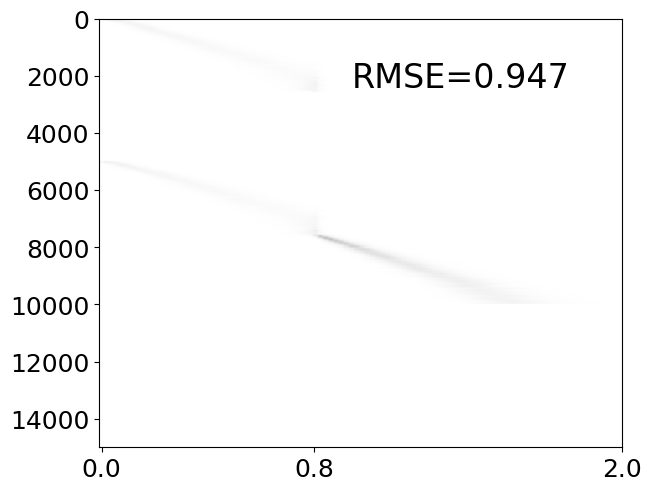

In [61]:
plot_t(traj1,l=0,t=true_t);
plot_t(traj1,l=1,t=true_t);
plot_t(traj1,l=2,t=true_t);

In [ ]:
from multiprocessing import Pool

Input_args = []

def fit_wrapper(seed):
    traj = Trajectory(topo2, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,fit_tau=False,norm_Q=True,params={'r':rd},perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
ts = time.time()
with Pool(50) as pool:      
    trajs2 = pool.starmap(fit_wrapper, Input_args, chunksize=1)
print((time.time()-ts)/60/60)

In [ ]:
with open('results/simulations_disconnect/topo2_fix_tau_results.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(trajs2, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
from multiprocessing import Pool

Input_args = []

def fit_wrapper(seed):
    traj = Trajectory(topo2, tau, model="two_species_ss", verbose=0)
    traj = traj.fit(X,m=100,n_init=1,fit_tau=True,norm_Q=True,params={'r':rd},perm_theta=False,epoch=100,parallel=False,n_threads=1,seed=seed)
    return traj
    
for seed in range(100):
    Input_args.append([seed])
            
ts = time.time()
with Pool(50) as pool:      
    trajs2 = pool.starmap(fit_wrapper, Input_args, chunksize=1)
print((time.time()-ts)/60/60)

In [ ]:
with open('results/simulations_disconnect/topo2_results.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(trajs2, f, pickle.HIGHEST_PROTOCOL)

In [100]:
with open('results/simulations_disconnect/topo2_results.pickle', 'rb') as f:
    trajs2 = pickle.load(f)

-414.8062648281414


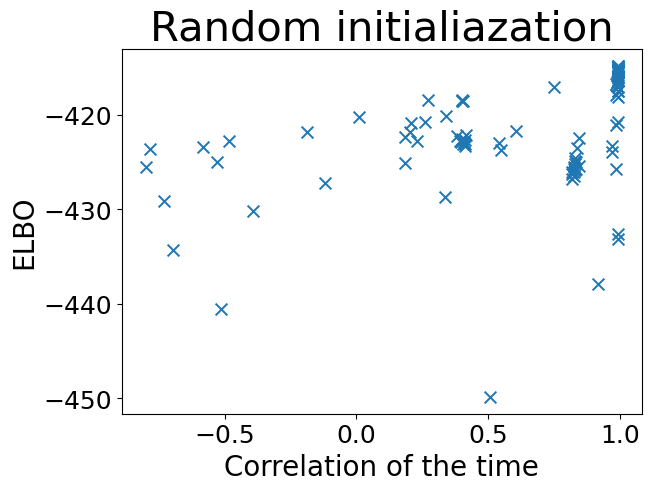

In [113]:
corrs = []
elbos = []
right_t = true_t
for traj in trajs2:
    t_hat = traj.Q.sum(1) @ traj.t
    corrs.append(stats.pearsonr(right_t[:10000],t_hat[:10000])[0])
    elbos.append( traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])][-1] )
plt.scatter(corrs,elbos,s=1,marker='x')
#plt.axhline(y=Elbos['warm start'],color='gray')
plt.xlabel('Correlation of the time',fontsize=20)
plt.ylabel('ELBO',fontsize=20)
plt.title('Random initialiazation',fontsize=30)

traj2 = trajs2[np.argmax(elbos)]
print(np.max(elbos))

In [102]:
traj2.fit_global_tau

True

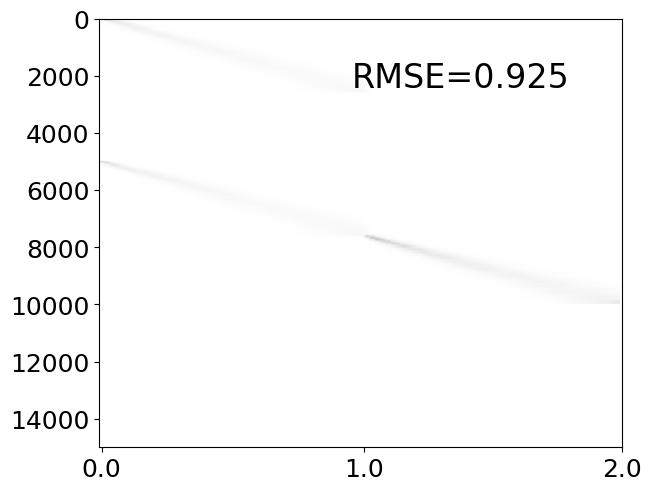

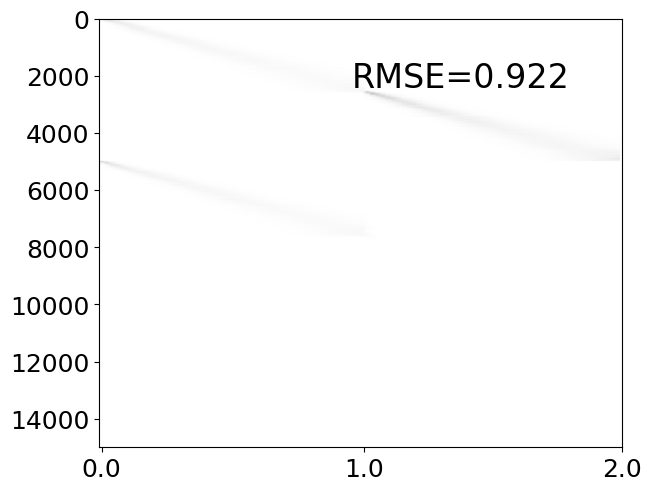

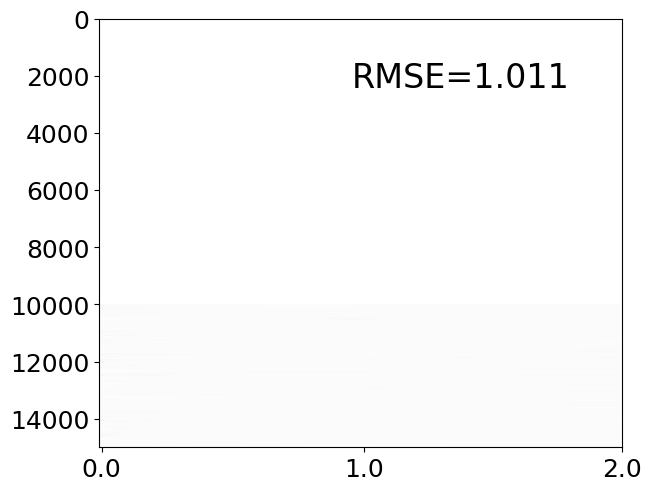

In [89]:
plot_t(traj2,l=0,t=true_t);
plot_t(traj2,l=1,t=true_t);
plot_t(traj2,l=2,t=true_t);

In [90]:
traj0.compute_AIC(X),traj1.compute_AIC(X),traj2.compute_AIC(X)

(12451442.856315866, 12513471.634276321, 12447787.944844242)

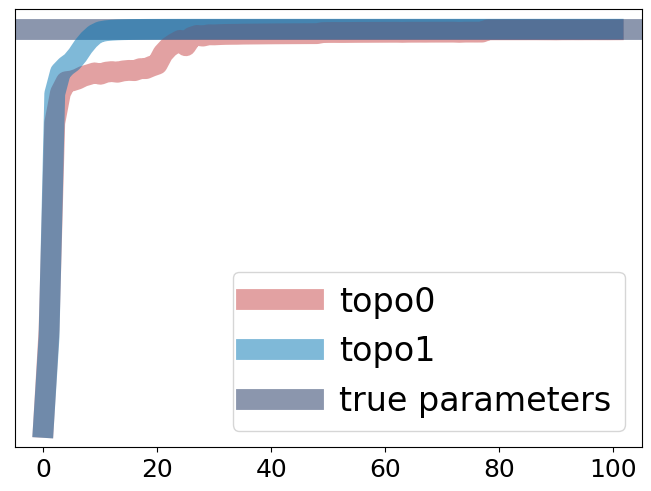

In [85]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.8))

ax.plot(traj0.elbos[0][:],'-',linewidth=15,markersize=30,label='topo0',color='#c74546',alpha=0.5)
ax.plot(traj2.elbos[0][:],'-',linewidth=15,markersize=30,label='topo1',color='#0074b3',alpha=0.5)

ax.axhline(y=true_L,ls='-',linewidth=15,color='#8b96ad',label='true parameters',zorder=0)
#ax.axhline(y=complete_L,ls='--',color='rosybrown',label='complete data likelihood')

#ax.set_xlabel('Iterations')
ax.axes.get_yaxis().set_visible(False)
#ax.set_ylabel('ELBO',fontsize=24);
plt.legend(loc="lower right",fontsize=legend_font);

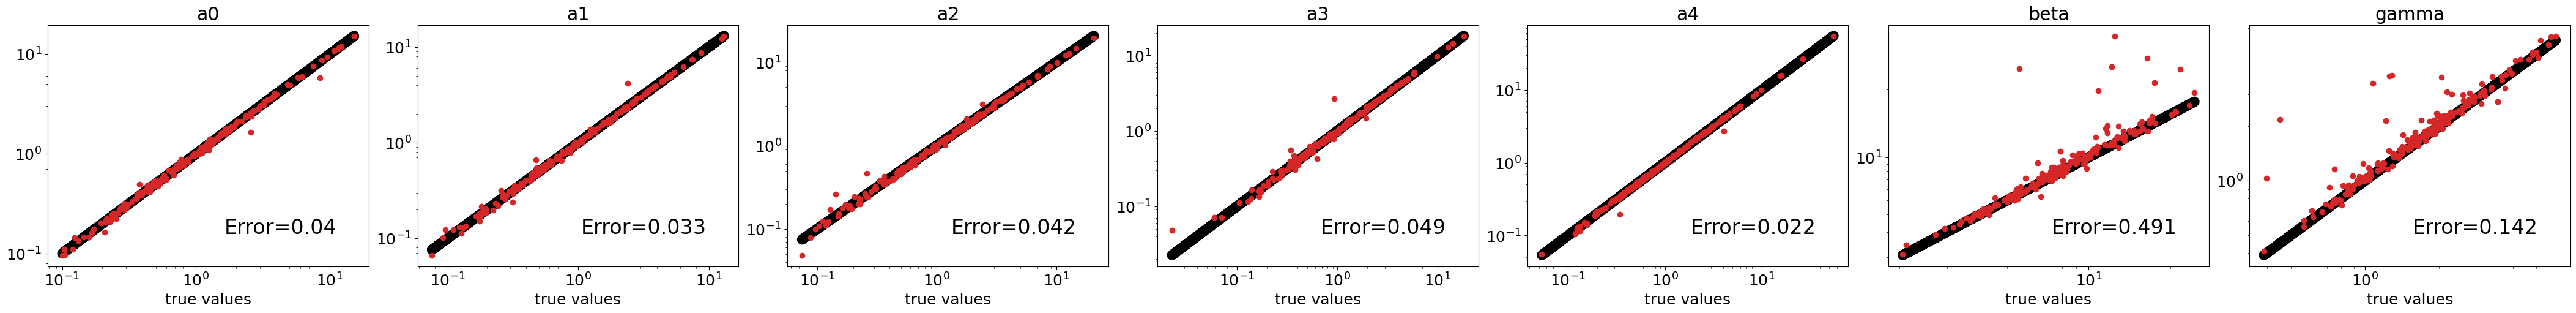

In [117]:
plot_theta(true_theta[:,[0,1,3,2,4,-2,-1]],traj0.theta);

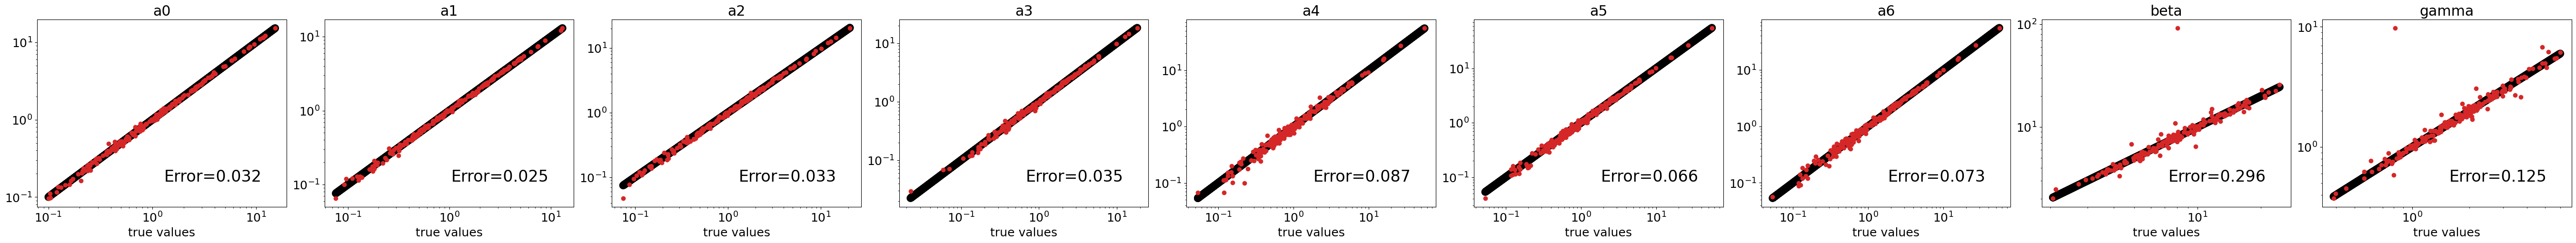

In [86]:
plot_theta(true_theta[:,[0,1,3,2,4,4,4,-2,-1]],traj2.theta);

In [193]:
aic_values = [traj0.compute_AIC(X, standard=True),
              PMSS.compute_AIC(X,standard=True),
              traj1.compute_AIC(X, standard=True)]

bic_values = [traj0.compute_BIC(X, standard=True), 
              PMSS.compute_BIC(X,standard=True),
              traj1.compute_BIC(X, standard=True)]

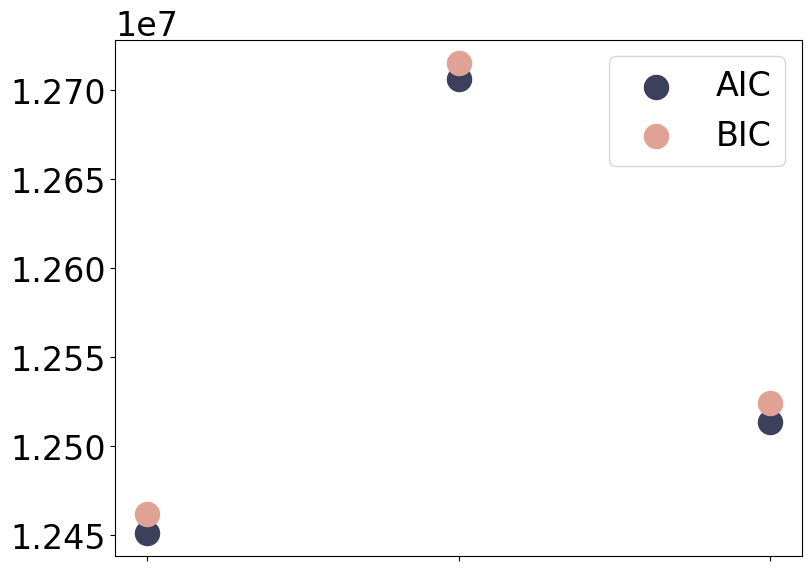

In [198]:
# Create scatter plot
plt.figure(figsize=(8,5.6))
plt.scatter([0, 1, 2], aic_values,color="#3d405b",s=300,label='AIC')
plt.scatter([0, 1, 2], bic_values,color='#e0a295',s=300,label='BIC')

# Set x-ticks to 0, 1, and 2
plt.xticks([0, 1, 2], ['', '', ''])

plt.legend(fontsize=24)

## Applying  on multiple datasets

In [ ]:
n=5000

Input_args = []

def fit_wrapper(seed):
    true_theta, true_t, Y, X, rd = simulate_demo_data(true_topo, true_tau, n=n, random_seed=seed, filepath=None, plot=False);
    r = rd/rd.mean()

    traj1 = Trajectory(topo, tau, model="two_species_ss", verbose=0)
    traj1 = traj1.fit(X,warm_start=False,params={'r':r},n_init=20,epoch=100,parallel=False)
    
    traj0 = Trajectory(true_topo, true_tau, model="two_species_ss", verbose=0)
    traj0 = traj0.fit(X,warm_start=False,params={'r':r},n_init=20,epoch=100,parallel=False)
    
    traj0.true_theta = true_theta.copy()   
    traj0.true_t = true_t.copy()
    traj0.Y = Y.copy()
    
    return (traj0,traj1)
    
for seed in range(20):
    Input_args.append([seed])
            
with Pool(20) as pool:      
    trajs_ms = pool.starmap(fit_wrapper, Input_args, chunksize=1)

In [228]:
with open('results/simulation_test/ms.pickle', 'wb') as f:
    pickle.dump(trajs_ms, f, pickle.HIGHEST_PROTOCOL)

In [248]:
seed = 19

true_theta, true_t, Y, X, rd = simulate_demo_data(true_topo, true_tau, n=n, random_seed=seed, filepath=None, plot=False);
r = rd/rd.mean()

traj0, traj1 = trajs_ms[seed]
traj0.compute_AIC(traj1.X), traj1.compute_AIC(traj1.X)

(-408.1933710795755, -407.8549953549901)

<AxesSubplot:>

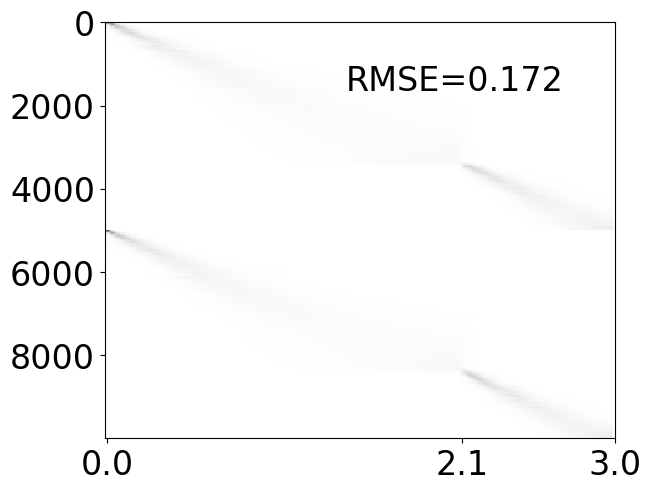

In [249]:
plot_t(traj0,t=traj0.true_t)

In [250]:
traj0.tau, traj1.tau

(array([0.        , 2.09406141, 3.        ]),
 array([0.        , 0.34094795, 2.06222678, 3.        ]))

In [251]:
traj0.compute_BIC(X),traj1.compute_BIC(X)

(-408.6096123679016, -408.33690955200177)

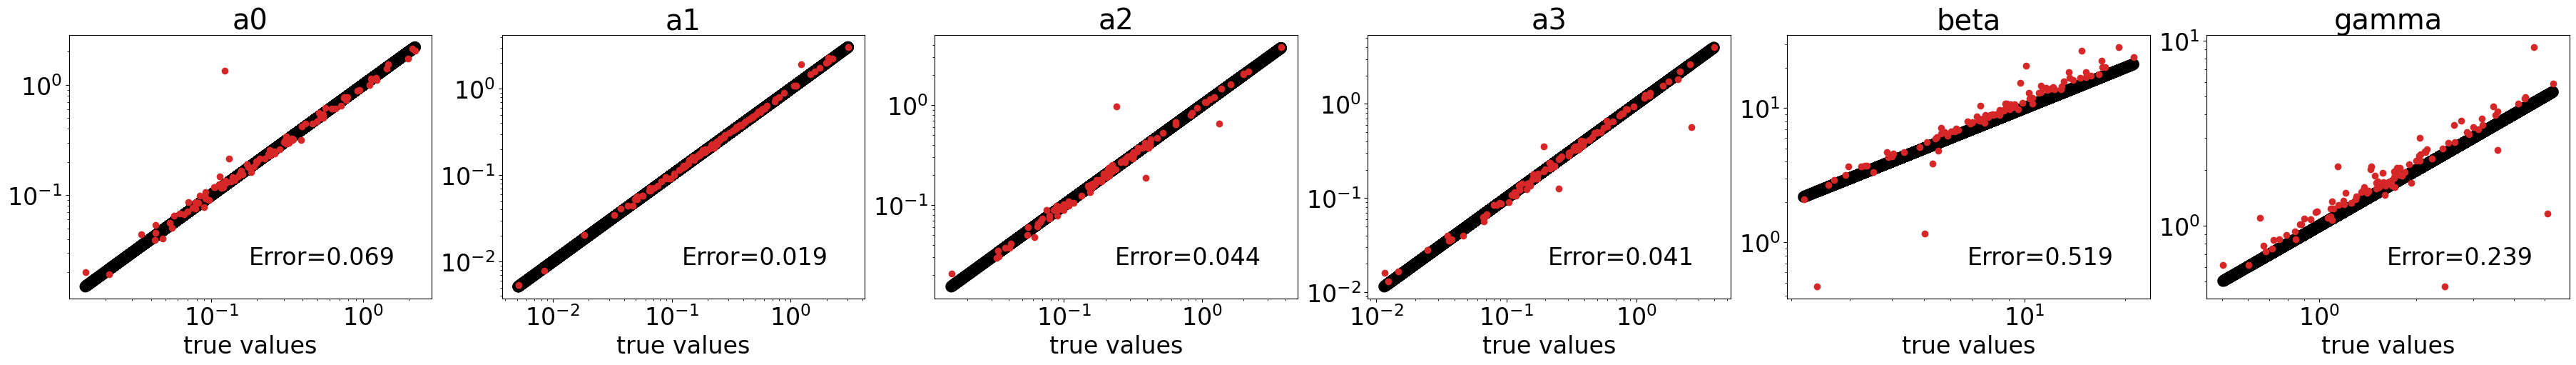

In [254]:
plot_theta(traj0.true_theta[:100,[0,1,3,2,-2,-1]],traj0.theta[:100]);

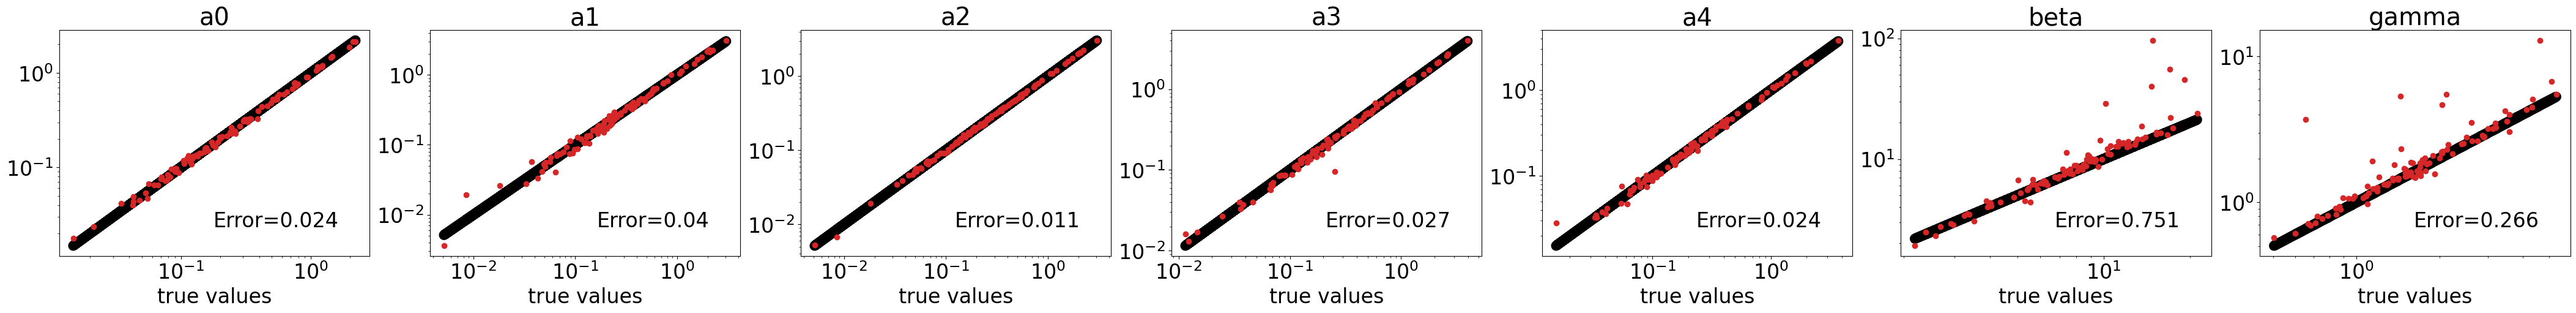

In [253]:
plot_theta(traj0.true_theta[:100,[0,1,1,2,3,-2,-1]],traj1.theta[:100]);

In [227]:
x=[]
y=[]
z=[]
w=[]
times=[]
KK=10
n=5000
L_idx = np.zeros(2*n,dtype=int)
L_idx[n:] = 1
for trajs in tqdm(trajs_ms):
    AIC = []
    BIC = []
    ELBO = []
    ELBO_out = np.zeros((2,KK))
    traj = trajs[0]
    Y = traj.get_Y_hat(theta=traj.true_theta, t=traj.true_t, tau=traj.tau, topo=traj.topo, params=traj.params)
    times.append(np.mean(np.abs(traj.true_t-traj.Q.sum(1)@traj.t)))
    for traj in trajs:
        AIC.append(traj.compute_AIC(traj.X))
        BIC.append(traj.compute_BIC(traj.X))
        ELBO.append(traj.compute_lower_bound(traj.X))
        
    for k in range(KK):
        X_test = np.random.poisson(traj.params['r'][:,None,None]*Y[L_idx,np.arange(2*n)])
        for j,traj in enumerate(trajs):
            ELBO_out[j,k] = traj.compute_lower_bound(X_test)
    x.append(np.argmax(AIC))
    y.append(np.argmax(BIC))
    z.append(np.argmax(ELBO))
    w.append(np.argmax(ELBO_out.mean(1)))

100%|██████████| 20/20 [02:20<00:00,  7.01s/it]


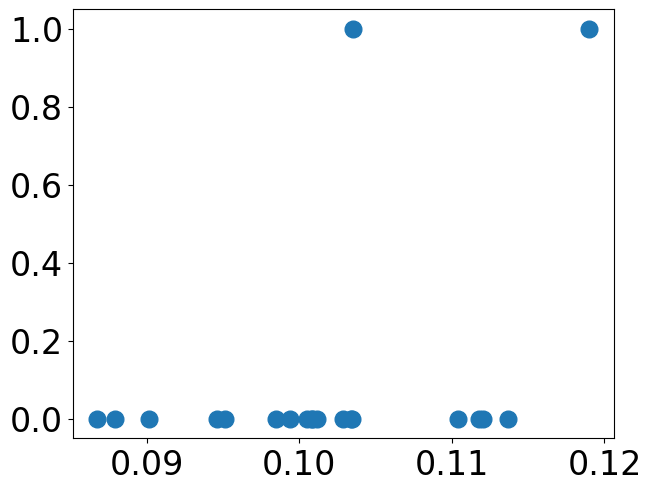

In [246]:
plt.scatter(times,w)

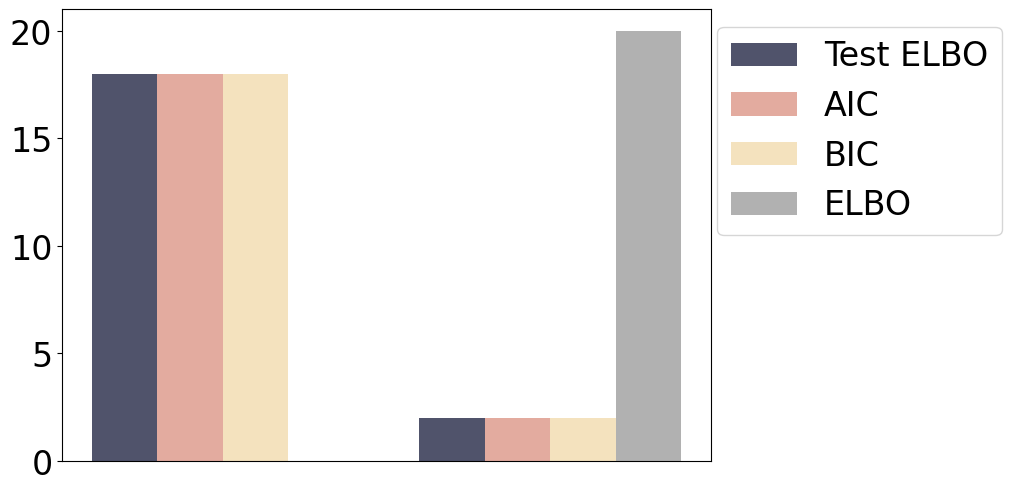

In [244]:
fig,ax = plt.subplots(1,1,figsize=(10,4.8))
ax.hist([w,x,y,z],label=["Test ELBO","AIC","BIC","ELBO"],bins=np.arange(3)-0.5,alpha=0.9,color=["#3d405b",'#e0a295',"#f3dfb7",'darkgray'])
ax.set_xticks([])
ax.legend(loc=(1.01,0.5),fontsize=legend_font)

In [ ]:
with open('results/simulations/simulation_demo_ri.pickle', 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)